# Multiclass classification (Hospital setting)

In this notebook we will see how to classify symptomatic rheumatic heart disease, from single lead wearable ECG recordings. We will first load the RHD-ECG data, then create a wavelet model for binary prediction of normal sinus rhythm (NSR) versus RHD (sse Notebook-1).
In the second experiment we will add age matched (<35y old) other diseases from PTB_XL dataset to simulate cardiac ward setting. The PTB_XL has five diagnostic superclasses (NSR, MI, HYP, CD, and ISC) as shown in the table-1 below. According to current epidemiological studies, the burden of cardiovascular diseases in major referral hospitals is ischaemic heart diseases(ISC/STTC), stroke caused by MI, and hypertensive heart disease (HHD/HYP). The merged resulting dataset is shown in table-2. 
The third experimet will merge RHD case with five diagnostic superclasses of PTB dataset for classification. Finally, we will see how we can use the model for arrhythmia classisification on PTB_XL dataset. we will show for the model will be superclasses as defined by the dataset.

PTB_XL dataset with diagnostic superclasses:
```
TABLE-1: PTB_XL dataset
Records | Superclass | Description
---------------------------------------------
9528    | NORM       | Normal ECG
3172    | MI         | Myocardial Infarction
1016    | STTC       | ST/T Change
1803    | CD         | Conduction Disturbance
2137    | HYP        | Hypertrophy
```

Age matched ECGs were extracted from PTB_XL dataset. There are five diagnostic classes (HYP,MI,ISC,CD, and NSR).

### PTB_XL subset(<35y old) + RHD
```
TABLE-2: PTB_XL dataset
Records     | Subjects  | Class
---------------------------------------------
 1575       | 1575       | NSR (Normal)
 34         | 34         | MI
 79         | 79         | ISC
103         | 103        | CD
40          | 40         | HYP
- - - - - - - - - - - - - - - - -  -
from RHDdB
46          | 46         | Normal
124         | 124        | RHD
```

In [1]:
import numpy as np 
import pandas as pd 
from scipy import signal, stats
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
plt.style.use('default')
from scipy.io import loadmat, savemat
import os, re, itertools, warnings, random# !pip install tensorflow==2.11.0

import plotly.express as px
from scipy import stats
from sklearn.utils import resample
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import nested_dict as nd
import neurokit2 as nk
from operator import itemgetter
from itertools import cycle
from wavetf import WaveTFFactory
import rhdPre_process_melk_basecorect_rzal_test  as prep # scale+zscore+Bandpass rhdPre_process_melk_nobaseln_1   --rhdPreprocessing1 rhdPreprocess_zf_nobaseline, rhdPreprocess_zf2(withbaseline)
import warnings
warnings.filterwarnings("ignore")

# Load Data Method

In [4]:
from scipy.signal import butter, sosfiltfilt, freqz,iirnotch, filtfilt,sosfreqz

######## Filter the datasets #############
def filter_dataset(data_in,rate,desired_fs, high,low,peak_height=0.5, threshold=0.99, order=4,secs=10):
    data_filt=[]
    if len(data_in)<=1:data_in.reshape(1,-1)
    for j in range(len(data_in)):
        # Bandpass the signals, and antialias 
        b, a = signal.butter(N=order, Wn=[0.5,100], btype='bandpass', fs=rate, analog=False) # pass fc/(fs/2)=0.48 = 120/(500/2) fc=120Hz 
        rec_filt = nk.ecg_clean(np.pad(data_in[j].reshape(-1),pad_width=(2000,0), mode='constant',constant_values=data_in[j][0]),highcut=100,lowcut=0.5,sampling_rate=rate,order=order)
#         rec_filt = signal.filtfilt(b, a, data_in[j].reshape(-1))
#         # Remove PLI noise
#         b, a = signal.iirnotch(50, Q = 40, fs = rate)
#         rec_filt = signal.filtfilt(b, a, rec_filt)
    
        # Downsample
        resampled_sig = nk.signal_resample(rec_filt.reshape(-1)[-int(secs*rate):], method="resample_method", sampling_rate=rate, desired_sampling_rate=desired_fs)
        filtered_signals = prep.baseline_correct(resampled_sig)
        
        ############################## 2) Finding R-peak  ###########################################################
        peaks_data,_ = signal.find_peaks(filtered_signals,distance=100,height=peak_height)

        ############################## 3) Find Outlier R-peak based on qualntiles  ##################################
        # boxplot
        df = pd.DataFrame({'Rpeaks': filtered_signals[peaks_data].T})
        # Find quantile ranges 
        quantiles = df.quantile([0.01, 0.25, 0.5, 0.75, threshold])

        ############################## 4) Cut segment /Remove outliers  ###################################
        upper_threshold=quantiles.iloc[4][0]
        cutoff_threshold=quantiles.iloc[1][0]
        lower_threshold=quantiles.iloc[0][0]
        mask_outliers = np.array(np.where(filtered_signals > cutoff_threshold) or np.where(filtered_signals < lower_threshold))
        outlier_peaks = [mask_outliers[0][ii] for ii in range(mask_outliers.shape[1]) if mask_outliers[0][ii] in peaks_data]
        if mask_outliers.shape[1] > 0:
            ############################## 5) Crop / Rescale after outlier removal  ###########################################
            range_max= cutoff_threshold #np.max(filtered_signals[~mask_outliers],axis=1)
            range_min=np.min(filtered_signals,axis=0)
            filtered_signals[mask_outliers]= cutoff_threshold
            X_std = (filtered_signals - range_min) / (range_max - range_min)
            X_scaled =  X_std * (range_max - range_min) + range_min
        else:
            X_scaled = filtered_signals
        ############################## 6) Now Take (z-norm) for all datasamples  ######################################################
        X_scaled = stats.zscore(X_scaled)
        data_filt.append(resampled_sig)
    return data_filt

## Down-sample by 250Hz

In [8]:
# read all data----- split into K-folds based on subjects
file_indx_list =[]
idx_folds = []
num_fold = 5
dpath='C:/Users/u0143922/OneDrive - KU Leuven/Experiments/Data/ptbdb_normal/'

dataset_loc1 = dpath+"../RHD-ECG/normal_data/"
dataset_loc2 = dpath+"../RHD-ECG/rhd_data/"
def chunks(l, n):
    for i in range(0, n):
        yield l[i::n]

def load_data(d_type):

    file_indx_list = []
    filelist = []       

    # store all the file names in this list
    if d_type == 'normal':
        data_path = dataset_loc1
    else:
        data_path = dataset_loc2

    for root, dirs, files in os.walk(data_path):
        for file in files:
          #append the file name to the list
          if(file.endswith(".mat")):
            filelist.append(os.path.join(root,file))
            file_id = [int(s) for s in re.findall("\d+", os.path.join(root,file)) ]
            file_indx_list.append(file_id[1])


    # uniquily split the data subject wise
    idx_all = np.unique(file_indx_list) 
    if d_type=='rhd':
        idx_all_bfold = np.random.choice(np.arange(1,len(idx_all)+1,1), size=len(idx_all), replace=False)    
    else:
        idx_all_bfold =np.random.choice(np.arange(1001,1001+len(idx_all),1), size=len(idx_all), replace=False)# 1001 is the start index of foldernames 

    # Chunk in to K-folds
    idx_K_split = chunks(idx_all_bfold,num_fold) #k=5
    idx_folds = np.array([i for i in idx_K_split])
    #print('Subject indexes: ', np.hstack(idx_folds))    
    return filelist, file_indx_list, idx_folds
    
def load_data_kfold(fold, desired_fs,d_type_in,metafeat=None):
    ecg_train = []
    ecg_test = []
    metafeat_train=[]
    metafeat_test=[]
    rec_list = []
    rec_list_train=[]
    fold_lap = fold

    print(f"\n....... Loading rhd-ecg data {d_type_in} subjects....." )
    
    rate = 500  #sampling frequency
    secs = 10
    if d_type_in=='normal':
        metafeat = np.array(metafeat.loc[metafeat['Class'] == 0])
    else:
        metafeat = np.array(metafeat.loc[metafeat['Class'] == 1])
    
    if d_type_in=='normal':
        files=filelist_normal
        file_indx_list=file_indx_list_normal
        idx_folds=idx_folds_normal    
    else:
        files=filelist_rhd
        file_indx_list=file_indx_list_rhd
        idx_folds=idx_folds_rhd

    def load_train_test( fold_lap,files, file_indx_list, idx_folds ):
        idx_test = idx_folds[fold_lap] 
        idx_train = [item for item in np.unique(file_indx_list) if item not in idx_test]
        print(f"....... Test foldset indices of {d_type_in} subjects..... {len(list(idx_test))}" , list(idx_test))
        
        plt.rcParams['figure.figsize']=[18,3]
        # TRAIN-TEST by SUBJECTS
        for name in files:
            # get the subject's folder id
            indx = [int(s) for s in re.findall("\d+", name) ]
            # Load the signal from .mat fie
            temp_ecg = loadmat(name)
            temp_ecg = temp_ecg['ECGrecord'].T
            # Arrange in 10sec length and reshape 
            #if len(temp_ecg)>5000:
            # Read record
            temp_ecg= temp_ecg[:-1,:]
            ## Toggle this for single record per subject
            
            if d_type_in=='rhd':
                _, temp_ecg_ = prep.clean_data_rhd(name, indx, temp_ecg)
            else:
                _, temp_ecg_ = prep.clean_data_normal(name, indx, temp_ecg)
            if temp_ecg_.shape[0]==0:
                print('Noisy recording of the subject:', [indx[0],indx[3]])
            else:
                # Checking for less than 10s recording : basically one Normal subject
                if temp_ecg_.reshape(-1).shape[0] <5000:
                    print('Recording Less than 10s duration:', name)
                    temp_ecg_ = np.hstack((temp_ecg_))
                    
                rec = np.expand_dims(temp_ecg_.reshape(-1),axis=0)[:,:5000]
                 #Band-pass fltering-resampled
                resampled_sig = filter_dataset(data_in=rec.reshape(1,-1),rate=500,desired_fs=250, peak_height=0.5, threshold=0.99, high=100, low=0.1, order=4) #for lowpass 0.64*250/2 = 80Hz
                resampled_sig = np.concatenate(resampled_sig).ravel().reshape(-1)
                
                rec=resampled_sig[:(len(resampled_sig) - len(resampled_sig)%(secs*desired_fs))].reshape(-1,(secs*desired_fs))
                # append in either train or test based on the subject split index
                if indx[1] in idx_train or int(indx[1]-1000) in idx_train:
                    ecg_train.append(rec)
                    if d_type_in=='rhd':
                        metafeat_train.append(metafeat[indx[1]])
                    else:
                        metafeat_train.append(metafeat[int(indx[1]-1000)]) 
                    rec_list_train.append([indx[1], rec.shape[0]])  
                if indx[1] in idx_test or int(indx[1]-1000) in idx_test:
                    ecg_test.append(rec)
                    if d_type_in=='rhd':
                        metafeat_test.append(metafeat[indx[1]])
                    else:
                        metafeat_test.append(metafeat[int(indx[1]-1000)]) 
                    rec_list.append([indx[1], rec.shape[0]])  
                if rec.shape[1] <2500:
                    print('Empty subject:', name)
                    #print(rec.shape[1])

        return ecg_train, ecg_test, file_indx_list, idx_train, idx_test,rec_list_train,rec_list, metafeat_train,metafeat_test
    ecg_train, ecg_test, file_indx_list,idx_train, idx_test,rec_list_train,rec_list,metafeat_train,metafeat_test = load_train_test(fold_lap,files, file_indx_list, idx_folds)
    ecg_trainX = np.concatenate(ecg_train).ravel().reshape(-1,secs*desired_fs)
    ecg_testX = np.concatenate(ecg_test).ravel().reshape(-1,secs*desired_fs)
    metafeat_trainX = np.concatenate(metafeat_train).ravel().reshape(-1,metafeat.shape[1])
    metafeat_testX = np.concatenate(metafeat_test).ravel().reshape(-1,metafeat.shape[1])
    if d_type_in=='normal':
        ecg_trainY = np.zeros(ecg_trainX.shape[0])
        ecg_testY = np.zeros(ecg_testX.shape[0])
    else:
        ecg_trainY = np.ones(ecg_trainX.shape[0])
        ecg_testY = np.ones(ecg_testX.shape[0])
    rec_list = np.array(rec_list)
    rec_list_train = np.array(rec_list_train)
    ## Select single record randomly per subject for training
    df=pd.DataFrame(rec_list_train,columns=['Group_id','label'])
    df.index.name='index'
    #sel=df.groupby('Group_id').apply(lambda x: x.sample(1)).reset_index(level=[0]).reset_index(drop=True )
    #sel = df.groupby('Group_id').apply(lambda x: x.sample(1)).reset_index(level=0).reset_index()
    #sel = df.groupby('Group_id').apply(lambda x: x.sample(1)).reset_index(drop=True)
    sel = (
        df.groupby('Group_id').apply(lambda x: x.sample(1)).reset_index(level=0, drop=True)  # Avoid re-inserting Group_id
        .reset_index()  # This brings 'indx' (original index) into a column
    )
    ecg_trainX = ecg_trainX[np.in1d(np.arange(ecg_trainX.shape[0]), sel.index)]
    metafeat_trainX = metafeat_trainX[np.in1d(np.arange(metafeat_trainX.shape[0]), sel.index)]
    rec_list_train = rec_list_train[np.in1d(np.arange(rec_list_train.shape[0]), sel.index)]
    ecg_trainY = ecg_trainY[np.in1d(np.arange(ecg_trainY.shape[0]), sel.index)]

#     ## Select single record randomly per subject for NSR
#     df=pd.DataFrame(rec_list,columns=['Group_id','label'])
#     df.index.name='indx'
#     sel=df.groupby('Group_id').apply(lambda x: x.sample(1)).reset_index(level=[1]).reset_index(drop=True )
#     ecg_testX = ecg_testX[np.in1d(np.arange(ecg_testX.shape[0]), sel.indx)]

    
    
    return ecg_trainX, ecg_trainY, ecg_testX, ecg_testY, idx_test, rec_list, metafeat_trainX,metafeat_testX


### Helper functions

In [11]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization,ReLU, Activation, Add, Dropout, MaxPool1D, GlobalAveragePooling1D, AvgPool1D,Dense, Concatenate,Reshape
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras import layers as kl
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
 # Define Model and callbacks
def scheduler(epoch, lr=3e-3 ):
    if epoch < 100:
        return lr
    elif epoch < 300:
        return lr * tf.math.exp(-0.1)
    else:
        return lr * tf.math.exp(-0.01)
    
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 15.0
    lrate = initial_lrate * np.math.pow(drop,  
           np.math.floor((1+epoch)/epochs_drop))
    return lrate

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
loss_history = LossHistory()
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
callbacks_list = [loss_history, lrate, stop]

In [13]:
#Post-processing for Subject-wise prediction
def groupby_mean(a):
    # Sort array by groupby column
    b = a[a[:,0].argsort()]

    # Get interval indices for the sorted groupby col
    idx = np.flatnonzero(np.r_[True,b[:-1,0]!=b[1:,0],True])

    # Get counts of each group and sum rows based on the groupings & hence averages
    counts = np.diff(idx)
    avg = np.add.reduceat(b[:,1:],idx[:-1],axis=0)/counts.astype(float)[:,None]

    # Finally concatenate for the output in desired format
    return np.round_(np.c_[b[idx[:-1],0],avg].astype(int))

def groupby_subjects_mean(a):
    # Sort array by groupby column
    b = a[a[:,0].argsort()]

    # Get interval indices for the sorted groupby col
    idx = np.flatnonzero(np.r_[True,b[:-1,0]!=b[1:,0],True])

    # Get counts of each group and sum rows based on the groupings & hence averages
    counts = np.diff(idx)
    avg = np.add.reduceat(b[:,1:],idx[:-1],axis=0)/counts.astype(float)[:,None]

    # Finally concatenate for the output in desired format
    return np.round_(np.c_[b[idx[:-1],0],avg].astype(int))

def eval_multi_topk_fold(model, test_data, rec_list_ext, test_lbls):    
    model_name = model
    pred = model_name.predict(test_data)    
    rec_list2=rec_list_ext

    pred_all = []
    y_pred_all = []
    y_true_all = []
    y_pred_ptb = []
    y_true_ptb = []
    y_pred_rhdecg = []
    y_true_rhdecg = []
    track_list = []
    y_pred_once=[]
    y_true_once=[]
    for j in range(len(rec_list2)):
    #     print('J= ',j)
        if j==0:
            c=0
        else:
            c+=rec_list2[j-1][1]
        pred_k = np.argmax(pred[c : c+rec_list2[j][1]], axis=1)
        true_k = np.argmax(test_lbls[c : c+rec_list2[j][1]], axis=1)
        
        # compute top-k predictions
        
        prediction_probabilities_k = tf.math.top_k(pred[c : c+rec_list2[j][1]], k=2)   #top_k value
        dict_class_entries_k = prediction_probabilities_k.indices.numpy()
                
        y_top_k=[]

        for l in range(len(true_k)):
            if dict_class_entries_k[l][0]==true_k[l]:
                p_k=dict_class_entries_k[l][0]
            elif dict_class_entries_k[l][1]==true_k[l]:
                p_k=dict_class_entries_k[l][1]
            else:
                p_k=np.argmax(pred[c : c+rec_list2[j][1]], axis=1)[l]
#                 print('no option ',[l,p_k])
            y_top_k.append(p_k)
        
        pred_k=np.array(y_top_k)

        normal_pred = np.count_nonzero(pred_k ==0)
        rhd_pred =  np.count_nonzero(pred_k ==1)
        STTC_pred =  np.count_nonzero(pred_k ==2)
        HYP_pred =  np.count_nonzero(pred_k ==3)
        CD_pred =  np.count_nonzero(pred_k ==4)
        MI_pred =  np.count_nonzero(pred_k ==5)
        y_pred = np.argmax(np.array([normal_pred,rhd_pred,STTC_pred,HYP_pred,CD_pred,MI_pred]),axis=0)

        y_pred_all.append((rec_list2[j][0],y_pred))
        y_true_all.append((rec_list2[j][0],true_k[0]))

        if rec_list_ext[j][0] <10000:
            y_pred_rhdecg.append((rec_list2[j][0],y_pred))
            y_true_rhdecg.append((rec_list2[j][0],true_k[0]))

        track_list.append(rec_list2[j][0])
        
    y2x=np.array(sorted(y_true_all, key=itemgetter(0)))
    y1x=np.array(sorted(y_pred_all, key=itemgetter(0)))
    y_pred_subject_x=groupby_mean(y1x)
    y_true_subject_x=groupby_mean(y2x)
    y_t_x, y_p_x = y_true_subject_x[:,1], y_pred_subject_x[:,1]

    y2x=np.array(sorted(y_true_rhdecg, key=itemgetter(0)))
    y1x=np.array(sorted(y_pred_rhdecg, key=itemgetter(0)))
    y_pred_subject_x=groupby_mean(y1x)
    y_true_subject_x=groupby_mean(y2x)
    y_t_rhdecg, y_p_rhdecg = y_true_subject_x[:,1], y_pred_subject_x[:,1]
    
    return y_t_x, y_p_x, y_t_rhdecg, y_p_rhdecg  #, y_t_ptb, y_p_ptb

def eval_multi_fold(model, test_data, rec_list_ext, test_lbls):    
    
    model_name = model
    pred = model_name.predict(test_data)    
    rec_list2=rec_list_ext
    pred_all = []
    y_pred_all = []
    y_true_all = []
    y_pred_ptb = []
    y_true_ptb = []
    y_pred_rhdecg = []
    y_true_rhdecg = []
    track_list = []
    y_pred_once=[]
    y_true_once=[]
    for j in range(len(rec_list2)):
        if j==0:
            c=0
        else:
            c+=rec_list2[j-1][1]
        pred_k = np.argmax(pred[c : c+rec_list2[j][1]], axis=1)
        true_k = np.argmax(test_lbls[c : c+rec_list2[j][1]], axis=1)

        normal_pred = np.count_nonzero(pred_k ==0)
        rhd_pred =  np.count_nonzero(pred_k ==1)
        STTC_pred =  np.count_nonzero(pred_k ==2)
        HYP_pred =  np.count_nonzero(pred_k ==3)
        CD_pred =  np.count_nonzero(pred_k ==4)
        MI_pred =  np.count_nonzero(pred_k ==5)
        y_pred = np.argmax(np.array([normal_pred,rhd_pred,STTC_pred,HYP_pred,CD_pred,MI_pred]),axis=0)
        y_pred_all.append((rec_list2[j][0],y_pred))
        y_true_all.append((rec_list2[j][0],true_k[0]))

        if rec_list_ext[j][0] <10000:
            y_pred_rhdecg.append((rec_list2[j][0],y_pred))
            y_true_rhdecg.append((rec_list2[j][0],true_k[0]))

        track_list.append(rec_list2[j][0])
   
    y2x=np.array(sorted(y_true_all, key=itemgetter(0)))
    y1x=np.array(sorted(y_pred_all, key=itemgetter(0)))
    y_pred_subject_x=groupby_mean(y1x)
    y_true_subject_x=groupby_mean(y2x)
    y_t_x, y_p_x = y_true_subject_x[:,1], y_pred_subject_x[:,1]

    y2x=np.array(sorted(y_true_rhdecg, key=itemgetter(0)))
    y1x=np.array(sorted(y_pred_rhdecg, key=itemgetter(0)))
    y_pred_subject_x=groupby_mean(y1x)
    y_true_subject_x=groupby_mean(y2x)
    y_t_rhdecg, y_p_rhdecg = y_true_subject_x[:,1], y_pred_subject_x[:,1]
    
    return y_t_x, y_p_x, y_t_rhdecg, y_p_rhdecg  #, y_t_ptb, y_p_ptb

def eval_binary_fold(model, test_data, rec_list_ext, test_lbls):    
    
    model_name = model
    pred = model_name.predict(test_data)    
    rec_list2=rec_list_ext
    pred_all = []
    y_pred_all = []
    y_true_all = []
    y_pred_ptb = []
    y_true_ptb = []
    y_pred_rhdecg = []
    y_true_rhdecg = []
    track_list = []
    y_pred_once=[]
    y_true_once=[]
    for j in range(len(rec_list2)):
        if j==0:
            c=0
        else:
            c+=rec_list2[j-1][1]

        pred_k = np.argmax(pred[c : c+rec_list2[j][1]], axis=1)
        true_k = np.argmax(test_lbls[c : c+rec_list2[j][1]], axis=1)

        normal_pred = np.count_nonzero(pred_k ==0)
        rhd_pred =  np.count_nonzero(pred_k ==1)

        y_pred = np.argmax(np.array([normal_pred,rhd_pred]),axis=0)

        y_pred_all.append((rec_list2[j][0],y_pred))
        y_true_all.append((rec_list2[j][0],true_k[0]))

        if rec_list_ext[j][0] <10000:
            y_pred_rhdecg.append((rec_list2[j][0],y_pred))
            y_true_rhdecg.append((rec_list2[j][0],true_k[0]))
            
        track_list.append(rec_list2[j][0])
    
    y2x=np.array(sorted(y_true_all, key=itemgetter(0)))
    y1x=np.array(sorted(y_pred_all, key=itemgetter(0)))
    y_pred_subject_x=groupby_mean(y1x)
    y_true_subject_x=groupby_mean(y2x)
    y_t_x, y_p_x = y_true_subject_x[:,1], y_pred_subject_x[:,1]

    y2x=np.array(sorted(y_true_rhdecg, key=itemgetter(0)))
    y1x=np.array(sorted(y_pred_rhdecg, key=itemgetter(0)))
    y_pred_subject_x=groupby_mean(y1x)
    y_true_subject_x=groupby_mean(y2x)
    y_t_rhdecg, y_p_rhdecg = y_true_subject_x[:,1], y_pred_subject_x[:,1]
    
    return y_t_x, y_p_x, y_t_rhdecg, y_p_rhdecg  #, y_t_ptb, y_p_ptb

# Load PTB-XL dataset

In [14]:
# X_af =np.load('../Data/PysioNet/X_physionet_250Hz_multiclass_X_af_10s_40hz.npy',allow_pickle=True)
X_normal_ptb =np.load(dpath+'PTB_X_1Lead_35_clean_norm.npy',allow_pickle=True)#[:50,:]
X_STTC =np.load(dpath+'PTB_X_1Lead_35_clean_STTC.npy',allow_pickle=True)#[:110,:]
X_HYP =np.load(dpath+'PTB_X_1Lead_35_clean_HYP.npy',allow_pickle=True)#[:110,:]
X_CD =np.load(dpath+'PTB_X_1Lead_35_clean_CD.npy',allow_pickle=True)#[:110,:]
X_MI =np.load(dpath+'PTB_X_1Lead_35_clean_MI.npy',allow_pickle=True)#[:110,:]

# X_normals = X_normal_ptb
idx_norms = np.random.choice(np.arange(0,len(X_normal_ptb),1), size=len(X_normal_ptb), replace=False)  # Choose randomly from NSR_PTB
X_NSR = np.array([X_normal_ptb[r] for r in idx_norms])
idx_STTC = np.random.choice(np.arange(0,len(X_STTC),1), size=len(X_STTC), replace=False)  
X_STTC = np.array([X_STTC[r] for r in idx_STTC])
idx_HYP = np.random.choice(np.arange(0,len(X_HYP),1), size=len(X_HYP), replace=False)  
X_HYP = np.array([X_HYP[r] for r in idx_HYP])
idx_CD = np.random.choice(np.arange(0,len(X_CD),1), size=len(X_CD), replace=False)  
X_CD = np.array([X_CD[r] for r in idx_CD])
idx_MI = np.random.choice(np.arange(0,len(X_MI),1), size=len(X_MI), replace=False)  
X_MI = np.array([X_MI[r] for r in idx_MI])

print('Normal classes: ',X_normal_ptb.shape)
# print('Afib classes: ',X_af.shape)
print('STTC classes: ',X_STTC.shape)
print('HYP classes: ',X_HYP.shape)
print('CD classes: ',X_CD.shape)
print('MI classes: ',X_MI.shape)

Normal classes:  (1575, 2500)
STTC classes:  (79, 2500)
HYP classes:  (40, 2500)
CD classes:  (103, 2500)
MI classes:  (34, 2500)


In [15]:

################################
# Generate K-Folds for NSR class
###############################
num_fold_NSR = 5
idx_all_bfold_NSR=[]
idx_folds_NSR=[]

def load_data_NSR():
    # uniqeily split the data subject wise
    rand_NSR_size= 100#len(X_normal_ptb)#100
    idx_all_bfold_NSR = np.random.choice(np.arange(0,len(X_normal_ptb),1), size=rand_NSR_size, replace=False)    
    
    # Chunk in to K-folds
    idx_K_split_NSR = chunks(idx_all_bfold_NSR,num_fold_NSR) #k=5
    idx_folds_NSR = np.array([i for i in idx_K_split_NSR])
    return idx_all_bfold_NSR, idx_folds_NSR

idx_NSR, folds_NSR = load_data_NSR()

########## arrange data for each fold ######################

def load_NSR_kfold(fold,desired_fs,idx_all_bfold_NSR, idx_folds_NSR, metafeat=None):
    NSR_train = []
    NSR_test = []
    NSR_train_metafeat=[]
    NSR_test_metafeat=[]
    rec_list_NSR = []
    fold_lap_NSR = fold
        
    print(f"\n....... Loading Other Arrhythimias class data ........\n" )
    
    secs = 10
    metafeat = np.array(metafeat.loc[metafeat['Class'] == 0])
    
    idx_test_NSR = idx_folds_NSR[fold_lap_NSR] 
    idx_train_NSR = [item for item in np.unique(idx_all_bfold_NSR) if item not in idx_test_NSR]
    #print(f"....... Test foldset indices of others subjects....." , list(idx_test_NSR))
    #print(f"....... Train foldset indices of others subjects....." , list(idx_train_NSR))
    
    for t in idx_all_bfold_NSR:
        # append in either train or test based on the subject split index
        if t in idx_train_NSR:
            NSR_train.append(X_NSR[t])
            NSR_train_metafeat.append(metafeat[t])
        else:
            if t in idx_test_NSR:
                NSR_test.append(X_NSR[t])
                NSR_test_metafeat.append(metafeat[t])
                rec_list_NSR.append([t+10001, 1])  
        if X_NSR[t].shape[0] <secs*desired_fs:
            print('Empty subject:', t)
            print(X_NSR[t].shape[1])


    NSR_testX = np.concatenate(NSR_test).ravel().reshape(-1,secs*desired_fs)
    NSR_trainX = np.concatenate(NSR_train).ravel().reshape(-1,secs*desired_fs)
    NSR_train_metafeatX = np.concatenate(NSR_train_metafeat).ravel().reshape(-1,metafeat.shape[1])
    NSR_test_metafeatX = np.concatenate(NSR_test_metafeat).ravel().reshape(-1,metafeat.shape[1])
    NSR_testY = np.array([0 for i in range(len(NSR_testX))])
    NSR_trainY = np.array([0 for i in range(len(NSR_trainX))])
    rec_list_NSR = np.array(np.repeat(rec_list_NSR,1,axis=0))

    return NSR_trainX, NSR_trainY, NSR_testX, NSR_testY, idx_test_NSR, rec_list_NSR, NSR_train_metafeatX,NSR_test_metafeatX

##############################################################################################################

################################
# Generate K-Folds for STTC class
###############################
num_fold_STTC = 5
idx_all_bfold_STTC=[]
idx_folds_STTC=[]

def load_data_STTC():
    # uniquily split the data subject wise
    idx_all_bfold_STTC = np.random.choice(np.arange(0,len(X_STTC),1), size=len(X_STTC), replace=False)    
    
    # Chunk in to K-folds
    idx_K_split_STTC = chunks(idx_all_bfold_STTC,num_fold_STTC) #k=5
    idx_folds_STTC = np.array([i for i in idx_K_split_STTC])
    return idx_all_bfold_STTC, idx_folds_STTC

idx_STTC, folds_STTC = load_data_STTC()

########## arrange data in each fold ######################

def load_STTC_kfold(fold,desired_fs,idx_all_bfold_STTC, idx_folds_STTC, metafeat=None):
    STTC_train = []
    STTC_test = []
    STTC_train_metafeat = []
    STTC_test_metafeat = []
    rec_list_STTC = []
    fold_lap_STTC = fold
        
    print(f"\n....... Loading Other Arrhythimias class data ........\n" )
    
    secs = 10
    metafeat = np.array(metafeat.loc[metafeat['Class'] == 2])
    
    idx_test_STTC = idx_folds_STTC[fold_lap_STTC] 
    idx_train_STTC = [item for item in np.unique(idx_all_bfold_STTC) if item not in idx_test_STTC]
    #print(f"....... Test foldset indices of others subjects....." , list(idx_test_STTC))
    
    for t in idx_all_bfold_STTC:
        # append in either train or test based on the subject split index
        if t in idx_train_STTC:
            STTC_train.append(X_STTC[t])
            STTC_train_metafeat.append(metafeat[t])
        if t in idx_test_STTC:
            STTC_test.append(X_STTC[t])
            STTC_test_metafeat.append(metafeat[t])
            rec_list_STTC.append([t+40001, 1])  
        if X_STTC[t].shape[0] <secs*desired_fs:
            print('Empty subject:', t)
            print(X_STTC[t].shape[1])


    STTC_trainX = np.concatenate(STTC_train).ravel().reshape(-1,secs*desired_fs)
    STTC_testX = np.concatenate(STTC_test).ravel().reshape(-1,secs*desired_fs)
    STTC_train_metafeatX = np.concatenate(STTC_train_metafeat).ravel().reshape(-1,metafeat.shape[1])
    STTC_test_metafeatX = np.concatenate(STTC_test_metafeat).ravel().reshape(-1,metafeat.shape[1])
    STTC_testY = np.array([2 for i in range(len(STTC_testX))])
    STTC_trainY = np.array([2 for i in range(len(STTC_trainX))])
    rec_list_STTC = np.array(np.repeat(rec_list_STTC,1,axis=0))

    return STTC_trainX, STTC_trainY, STTC_testX, STTC_testY, idx_test_STTC, rec_list_STTC, STTC_train_metafeatX,STTC_test_metafeatX
###############################################################################################################

################################
# Generate K-Folds for HYPERTROPHY class
###############################
num_fold_HYP = 5
idx_all_bfold_HYP=[]
idx_folds_HYP=[]

def load_data_HYP():
    # uniquily split the data subject wise
    idx_all_bfold_HYP = np.random.choice(np.arange(0,len(X_HYP),1), size=len(X_HYP), replace=False)    
    
    # Chunk in to K-folds
    idx_K_split_HYP = chunks(idx_all_bfold_HYP,num_fold_HYP) #k=5
    idx_folds_HYP = np.array([i for i in idx_K_split_HYP])
    return idx_all_bfold_HYP, idx_folds_HYP

idx_HYP, folds_HYP = load_data_HYP()

########## arrange data in each fold ######################

def load_HYP_kfold(fold,desired_fs,idx_all_bfold_HYP, idx_folds_HYP, metafeat=None):
    HYP_train = []
    HYP_test = []
    HYP_train_metafeat=[]
    HYP_test_metafeat=[]
    rec_list_HYP = []
    fold_lap_HYP = fold
        
    #print(f"\n....... Loading Other Arrhythimias class data ........\n" )
    
    secs = 10
    metafeat = np.array(metafeat.loc[metafeat['Class'] == 3])
    
    idx_test_HYP = idx_folds_HYP[fold_lap_HYP] 
    idx_train_HYP = [item for item in np.unique(idx_all_bfold_HYP) if item not in idx_test_HYP]
    print(f"....... Test foldset indices of others subjects....." , list(idx_test_HYP))
    
    for t in idx_all_bfold_HYP:
        # append in either train or test based on the subject split index
        if t in idx_train_HYP:
            HYP_train.append(X_HYP[t])
            HYP_train_metafeat.append(metafeat[t])
        if t in idx_test_HYP:
            HYP_test.append(X_HYP[t])
            HYP_test_metafeat.append(metafeat[t])
            rec_list_HYP.append([t+45001, 1])  
        if X_HYP[t].shape[0] <secs*desired_fs:
            print('Empty subject:', t)
            print(X_HYP[t].shape[1])


    HYP_testX = np.concatenate(HYP_test).ravel().reshape(-1,secs*desired_fs)
    HYP_trainX = np.concatenate(HYP_train).ravel().reshape(-1,secs*desired_fs)
    HYP_train_metafeatX = np.concatenate(HYP_train_metafeat).ravel().reshape(-1,metafeat.shape[1])
    HYP_test_metafeatX = np.concatenate(HYP_test_metafeat).ravel().reshape(-1,metafeat.shape[1])    
    HYP_testY = np.array([3 for i in range(len(HYP_testX))])
    HYP_trainY = np.array([3 for i in range(len(HYP_trainX))])
    rec_list_HYP = np.array(np.repeat(rec_list_HYP,1,axis=0))

    return HYP_trainX, HYP_trainY, HYP_testX, HYP_testY, idx_test_HYP, rec_list_HYP, HYP_train_metafeatX,HYP_test_metafeatX
###############################################################################################################
###############################################################################################################

################################
# Generate K-Folds for CONDUCTION DISTURBANCE class
###############################
num_fold_CD = 5
idx_all_bfold_CD=[]
idx_folds_CD=[]

def load_data_CD():
    # uniquily split the data subject wise
    idx_all_bfold_CD = np.random.choice(np.arange(0,len(X_CD),1), size=len(X_CD), replace=False)    
    
    # Chunk in to K-folds
    idx_K_split_CD = chunks(idx_all_bfold_CD,num_fold_CD) #k=5
    idx_folds_CD = np.array([i for i in idx_K_split_CD])
    return idx_all_bfold_CD, idx_folds_CD

idx_CD, folds_CD = load_data_CD()

########## arrange data in each fold ######################

def load_CD_kfold(fold,desired_fs,idx_all_bfold_CD, idx_folds_CD, metafeat=None):
    CD_train = []
    CD_test = []
    CD_train_metafeat=[]
    CD_test_metafeat=[]
    rec_list_CD = []
    fold_lap_CD = fold
        
    #print(f"\n....... Loading Other Arrhythimias class data ........\n" )
    
    secs = 10
    metafeat = np.array(metafeat.loc[metafeat['Class'] == 4])
    
    idx_test_CD = idx_folds_CD[fold_lap_CD] 
    idx_train_CD = [item for item in np.unique(idx_all_bfold_CD) if item not in idx_test_CD]
    print(f"....... Test foldset indices of others subjects....." , list(idx_test_CD))
    
    for t in idx_all_bfold_CD:
        # append in either train or test based on the subject split index
        if t in idx_train_CD:
            CD_train.append(X_CD[t])
            CD_train_metafeat.append(metafeat[t])
        if t in idx_test_CD:
            CD_test.append(X_CD[t])
            CD_test_metafeat.append(metafeat[t])
            rec_list_CD.append([t+55001, 1])  
        if X_CD[t].shape[0] <secs*desired_fs:
            print('Empty subject:', t)
            print(X_CD[t].shape[1])


    CD_testX = np.concatenate(CD_test).ravel().reshape(-1,secs*desired_fs)
    CD_trainX = np.concatenate(CD_train).ravel().reshape(-1,secs*desired_fs)
    CD_train_metafeatX = np.concatenate(CD_train_metafeat).ravel().reshape(-1,metafeat.shape[1])
    CD_test_metafeatX = np.concatenate(CD_test_metafeat).ravel().reshape(-1,metafeat.shape[1])     
    CD_testY = np.array([4 for i in range(len(CD_testX))])
    CD_trainY = np.array([4 for i in range(len(CD_trainX))])
    rec_list_CD = np.array(np.repeat(rec_list_CD,1,axis=0))

    return CD_trainX, CD_trainY, CD_testX, CD_testY, idx_test_CD, rec_list_CD, CD_train_metafeatX,CD_test_metafeatX
###############################################################################################################
###############################################################################################################

################################
# Generate K-Folds for MYOCARDIAL INFARCTION class
###############################
num_fold_MI = 5
idx_all_bfold_MI=[]
idx_folds_MI=[]

def load_data_MI():
    # uniquily split the data subject wise
    idx_all_bfold_MI = np.random.choice(np.arange(0,len(X_MI),1), size=len(X_MI), replace=False)    
    
    # Chunk in to K-folds
    idx_K_split_MI = chunks(idx_all_bfold_MI,num_fold_MI) #k=5
    idx_folds_MI = np.array([i for i in idx_K_split_MI])
    return idx_all_bfold_MI, idx_folds_MI

idx_MI, folds_MI = load_data_MI()

########## arrange data in each fold ######################

def load_MI_kfold(fold,desired_fs,idx_all_bfold_MI, idx_folds_MI, metafeat=None):
    MI_train = []
    MI_test = []
    MI_train_metafeat=[]
    MI_test_metafeat=[]
    rec_list_MI = []
    fold_lap_MI = fold
        
    #print(f"\n....... Loading Other Arrhythimias class data ........\n" )
    
    secs = 10
    metafeat = np.array(metafeat.loc[metafeat['Class'] == 5])
    
    idx_test_MI = idx_folds_MI[fold_lap_MI] 
    idx_train_MI = [item for item in np.unique(idx_all_bfold_MI) if item not in idx_test_MI]
    #print(f"....... Test foldset indices of others subjects....." , list(idx_test_MI))
    
    for t in idx_all_bfold_MI:
        # append in either train or test based on the subject split index
        if t in idx_train_MI:
            MI_train.append(X_MI[t])
            MI_train_metafeat.append(metafeat[t])
        if t in idx_test_MI:
            MI_test.append(X_MI[t])
            MI_test_metafeat.append(metafeat[t])
            rec_list_MI.append([t+75001, 1])  
        if X_MI[t].shape[0] <secs*desired_fs:
            print('Empty subject:', t)
            print(X_MI[t].shape[1])


    MI_testX = np.concatenate(MI_test).ravel().reshape(-1,secs*desired_fs)
    MI_trainX = np.concatenate(MI_train).ravel().reshape(-1,secs*desired_fs)
    MI_train_metafeatX = np.concatenate(MI_train_metafeat).ravel().reshape(-1,metafeat.shape[1])
    MI_test_metafeatX = np.concatenate(MI_test_metafeat).ravel().reshape(-1,metafeat.shape[1])
    MI_testY = np.array([5 for i in range(len(MI_testX))])
    MI_trainY = np.array([5 for i in range(len(MI_trainX))])
    rec_list_MI = np.array(np.repeat(rec_list_MI,1,axis=0))

    return MI_trainX, MI_trainY, MI_testX, MI_testY, idx_test_MI, rec_list_MI, MI_train_metafeatX,MI_test_metafeatX
###############################################################################################################

In [17]:
import tensorflow.keras.layers as layers
from keras.layers import Conv1D, Dropout, Dense, LSTM, Attention, Softmax, Flatten, RepeatVector,\
Permute, Dot,GlobalAveragePooling1D, ZeroPadding1D, MaxPooling1D, Conv1DTranspose, Layer, Bidirectional
from keras import regularizers,initializers,constraints
from tensorflow.keras.layers import Layer

class MLP(layers.Layer):
    def __init__(self, filter_num, drop=0.):
        
        super().__init__()
        
        # MLP layers
        self.fc1 = Dense(filter_num[0])
        self.fc2 = Dense(filter_num[1])
        
        # Dropout layer
        self.drop = Dropout(drop)
        
        # GELU activation
        self.activation = tf.keras.activations.gelu
        
    def call(self, x):
        
        # MLP --> GELU --> Drop --> MLP --> Drop
        x = self.fc1(x)
        self.activation(x)
        x = self.drop(x)

        x = self.fc2(x)
        self.activation(x)
        x = self.drop(x)
        
        return x


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # self.ffn = Model([layers.Dense(mlp_dim, activation="relu"), layers.Dense(embed_dim),] )
        
        self.mlp = MLP([mlp_dim, embed_dim], rate)
        self.layernorm = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        
        #Pre-post LNorm eval
        #out1 = self.layernorm(attn_output) + inputs #prenorm
        out1 = self.layernorm(inputs + attn_output) #postnorm

        mlp_output = self.mlp(out1)
        mlp_output = self.dropout2(mlp_output, training=training)
        
        out2 = self.layernorm(mlp_output) + out1

        return out2
    def get_config(self):
        config = super().get_config().copy()
        config.update({ 
            'att': self.att,
            'mlp': self.mlp,
            'layernorm': self.layernorm,
            'dropout1': self.dropout1,
            'dropout2': self.dropout2,
        })
        return config

class AbsolutePositionEmbedding(layers.Layer):
    def __init__(self, maxlen, patch_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=patch_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
### SwinT like embeddings
class patch_embeddings(tf.keras.layers.Layer):    
    def __init__(self, num_patch=32, embed_dim=64, patch_size=32, dropout=0.0, **kwargs):
        super(patch_embeddings, self).__init__()
        self.num_patch = num_patch
        self.proj = Conv1D(filters=embed_dim, kernel_size=patch_size, strides=patch_size)
        # self.proj = Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)
    def call(self, inputs):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        print(self.proj(inputs).shape)
        embed = self.proj(inputs) + self.pos_embed(pos)
        return embed
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_patch': self.num_patch,
            'pos_embed': self.pos_embed,
            'proj': self.proj,
        })
        return config


#%% Learning rate reduction
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=2, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=10)

#%% threshold
#To find the optimal threshold we will use Downhill simplex method
from scipy import optimize
def thr_chall_metrics(thr, label, output_prob):
    return -pc.compute_challenge_metric_for_opt(label, np.array(output_prob>thr))

def categorical_focal_loss(gamma=3.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss


In [19]:
def Attn_inception_fusion(ecg_len=3072, temporal_feats=None, num_channel = 1, num_classes=6, dim_metafeats=50):
    query = layers.Input(shape=(None,), dtype='int32')
    value = layers.Input(shape=(None,), dtype='int32')
    
    inputs = layers.Input((ecg_len, num_channel))
    conv1d1_1 = layers.Conv1D(16, 3, 1, padding="same", kernel_initializer = 'glorot_uniform') (inputs)
    bn1_1 = layers.BatchNormalization() (conv1d1_1)
    act1_1 = layers.Activation("elu") (bn1_1)
    #5x5
    conv1d1_2 = layers.Conv1D(16, 3, 1, padding="same", kernel_initializer = 'glorot_uniform') (inputs)
    x = layers.Conv1D(16, 3, 1, padding="same", kernel_initializer = 'glorot_uniform') (conv1d1_2)
    x = layers.BatchNormalization() (x)
    act1_2 = layers.Activation("elu") (x)
    #7x7
    conv1d1_3 = layers.Conv1D(16, 3, 1, padding="same", kernel_initializer = 'glorot_uniform') (inputs)
    x = layers.Conv1D(16, 3, 1, padding="same", kernel_initializer = 'glorot_uniform') (conv1d1_3)
    x = layers.Conv1D(16, 9, 1, padding="same", kernel_initializer = 'glorot_uniform') (x)
    x = layers.BatchNormalization() (x)
    act1_3 = layers.Activation("elu") (x)
     
    act1_attn=attention()(act1_1)
    act1_attn= RepeatVector(act1_3.shape[1])(act1_attn)
    filter_concat_1 = layers.Concatenate()([act1_1, act1_2, act1_3, act1_attn])

    conv1d2_1 = layers.Conv1D(32, 3, 1, padding="same", kernel_initializer = 'glorot_uniform') (filter_concat_1)
    bn2_1 = layers.BatchNormalization() (conv1d2_1)
    act2_1 = layers.Activation("elu") (bn2_1)
    #5x5
    conv1d2_2 = layers.Conv1D(32, 3, 1, padding="same", kernel_initializer = 'glorot_uniform') (filter_concat_1)    
    x = layers.Conv1D(32, 3, 1, padding="same", kernel_initializer = 'glorot_uniform') (filter_concat_1)
    x = layers.BatchNormalization() (x)
    act2_2 = layers.Activation("elu") (x)
    # 7x7
    conv1d2_3 = layers.Conv1D(32, 3, 1, padding="same", kernel_initializer = 'glorot_uniform') (filter_concat_1)
    x = layers.Conv1D(32, 1, 1, padding="same", kernel_initializer = 'glorot_uniform') (conv1d2_3)
    x = layers.Conv1D(32, 9, 1, padding="same", kernel_initializer = 'glorot_uniform') (x)
    x = layers.BatchNormalization() (x)
    act2_3 = layers.Activation("elu") (x)

    act2_attn=attention()(act2_1)
    act2_attn= RepeatVector(act2_3.shape[1])(act2_attn)
    filter_concat_2 = layers.Concatenate()([act2_1, act2_2, act2_3])

    conv1d3_1 = layers.Conv1D(64, 3, 1, padding="same", kernel_initializer = 'glorot_uniform') (filter_concat_2)
    bn3_1 = layers.BatchNormalization() (conv1d3_1)
    act3_1 = layers.Activation("elu") (bn3_1)
    conv1d3_2 = layers.Conv1D(64, 1, 1, padding="same", kernel_initializer = 'glorot_uniform') (filter_concat_2)
    bn3_2 = layers.BatchNormalization() (conv1d3_2)
    act3_2 = layers.Activation("elu") (bn3_2)
    conv1d3_3 = layers.Conv1D(64, 9, 1, padding="same", kernel_initializer = 'glorot_uniform', name='last_conv') (filter_concat_2)
    bn3_3 = layers.BatchNormalization() (conv1d3_3)
    act3_3 = layers.Activation("elu") (bn3_3)
    filter_concat_3 = layers.Concatenate()([act3_1, act3_2, act3_3])
       

    gru_1 = Bidirectional(layers.GRU(128, dropout=0.5, return_sequences=True)) (filter_concat_3)
    act3_attn=attention()(act1_1)
    act3_attn= RepeatVector(gru_1.shape[1])(act3_attn)
    gru_concat = layers.Concatenate()([gru_1, act3_attn])
    gru_2 = Bidirectional(layers.GRU(64, dropout=0.25, return_sequences=True)) (gru_concat)
    gru_3 = Bidirectional(layers.GRU(32, dropout=0.25, return_sequences=True)) (gru_concat)
    
    # 1. Early fusion 
    gap = layers.GlobalAveragePooling1D()(gru_3)
    gap = layers.Activation("relu") (gap)

#      # Metadata Branch
    input_meta = Input(shape=(dim_metafeats,), name='metadata_input')  # N×50 temporalRWE features
    x_tempFeat = layers.Dense(64, activation='relu')(input_meta)
#     combined = layers.Concatenate(axis=-1)([gap, x_tempFeat])  # 64 + 32 = 96 features

#     #2. Intermediate Fusion (Attention-Based)
    # After CNN feature extraction (x shape: (None, 64))
    atten = layers.Attention()([gap, x_tempFeat])  # Cross-modal attention
    combined = Concatenate()([gap, atten])
    
    fc = layers.Dense(256, activation="relu")(combined)
    fc = layers.Dropout(0.2)(fc)
    fc = layers.Dense(32, activation="relu")(fc)
    
    outputs = layers.Dense(num_classes, activation="softmax") (fc)

    model = Model([inputs,input_meta], outputs)
    return model


from tensorflow import keras
from tensorflow.keras.layers import Multiply, Input, Conv1D, DepthwiseConv1D, SeparableConv1D, LeakyReLU, BatchNormalization, ReLU,  \
     Activation, Add, Dropout, MaxPool1D, GlobalMaxPool1D, GlobalAvgPool1D, AvgPool1D,Dense, Concatenate,Reshape,Flatten
from tensorflow.keras import Model
from keras.callbacks import History, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model

#  InceptionTime model

#https://github.com/hfawaz/InceptionTime
def _inception_module( input_tensor, stride=1, activation='linear', use_bottleneck=True,bottleneck_size=16, kernel_size=7,nb_filters=32):

    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = Conv1D(filters=bottleneck_size, kernel_size=1,
                                              padding='same', activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    kernel_size_s = [11, 7, 5, 3, 3]
    kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
    nb_filters=nb_filters
    conv_list = []
    for i in range(len(kernel_size_s)):
        conv_list.append(Conv1D(filters=nb_filters, kernel_size=kernel_size_s[i],
                                             strides=stride, padding='same', activation=activation, use_bias=False)(
            input_inception))

    max_pool_1 = MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

    conv_6 = Conv1D(filters=nb_filters, kernel_size=1,
                                 padding='same', activation=activation, use_bias=False)(max_pool_1)

    conv_list.append(conv_6)

    x = Concatenate(axis=2)(conv_list)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    return x

def _shortcut_layer( input_tensor, out_tensor, num_heads, mlp_dim):
    shortcut_y = Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                     padding='same', use_bias=False)(input_tensor)
    shortcut_y = BatchNormalization()(shortcut_y)

    x = Add()([shortcut_y, out_tensor])
    x = Activation('relu')(x)
    return x

def build_model( input_shape, num_classes, depth, use_bottleneck,bottleneck_size, nb_filters, kernel_size=11,num_heads=3,mlp_dim=64,dim_metafeats=46):
    use_residual = True
    input_layer = Input(input_shape)

    x = input_layer
    input_res = input_layer

    for d in range(depth):

        x = _inception_module(x, use_bottleneck= True,bottleneck_size=bottleneck_size,nb_filters=nb_filters)

        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x, num_heads,mlp_dim)
            input_res = x

    gap_layer = GlobalAvgPool1D()(x)
#      # Metadata Branch
    input_meta = Input(shape=(dim_metafeats,), name='metadata_input')  # N×50 temporalRWE features
    x_tempFeat = layers.BatchNormalization() (input_meta)
    x_tempFeat = layers.Dense(128, activation='relu')(x_tempFeat)

    combined = layers.Concatenate(axis=-1)([gap_layer, x_tempFeat])  # 64 + 128  features

    fc = layers.Dense(512, activation="relu")(combined)
    fc = layers.Dropout(0.4)(fc)
    fc = layers.Dense(128, activation="relu")(fc)
    

    
    output_layer = Dense(num_classes, activation='softmax')(gap_layer)#gap_layer

    model = Model(inputs=[input_layer, input_meta], outputs=output_layer)

    return model

def model_inceptionTime(input_shape, depth, num_classes,ks,nb_epochs,num_channel = 1, num_heads=5, mlp_dim=64, embed_dim=64, patch_size=32, dim_metafeats=46):
    output_directory = './'
    nb_filters = 32
    use_residual = True
    use_bottleneck = True
    depth = depth
    kernel_size = ks - 1
    callbacks = None
    batch_size = 32
    bottleneck_size = 16
    build=True
    verbose = False
    num_classes=num_classes
    num_channel = num_channel
    num_heads=num_heads
    mlp_dim=mlp_dim
    embed_dim=embed_dim
    patch_size=patch_size
    num_classes=num_classes 
    
    model = build_model(input_shape, num_classes,depth, use_bottleneck,bottleneck_size,nb_filters,num_heads,mlp_dim,dim_metafeats)
    return model


model_cnn = model_inceptionTime(input_shape=(2048,1), depth=6, num_classes=6, ks=17, nb_epochs=30, num_channel = 1, num_heads=5, mlp_dim=64, embed_dim=64, patch_size=32, dim_metafeats=46)

In [20]:
#%% Inception1D dialated conn
# https://doi.org/10.1016/j.future.2024.06.016
from tensorflow.keras.regularizers import l2
import tensorflow_addons as tfa  # for WeightNormalization

def TCNResidualBlock(filters, kernel_size, dilation_rates, l2_reg=0.01, dropout_rate=0.2):
    def block(x_input):
        res = x_input
        for dilation_rate in dilation_rates:
            # First dilated causal conv block
            x = tfa.layers.WeightNormalization(
                    layers.Conv1D(filters, kernel_size, padding='causal',
                                  dilation_rate=dilation_rate,
                                  kernel_regularizer=l2(l2_reg)))(x_input)
            x = layers.ReLU()(x)
            x = layers.Dropout(dropout_rate)(x)
    
            # Second dilated causal conv block
            x = tfa.layers.WeightNormalization(
                    layers.Conv1D(filters, kernel_size, padding='causal',
                                  dilation_rate=dilation_rate,
                                  kernel_regularizer=l2(l2_reg)))(x)
            x = layers.ReLU()(x)
            x = layers.Dropout(dropout_rate)(x)
    
            # Optional 1x1 conv on residual to match shape
            if res.shape[-1] != filters:
                res = layers.Conv1D(filters, kernel_size=1, padding='same')(res)
            x = layers.Add()([x, res])
            
        return x
    
    return block


# ---- Inception Module ----
def InceptionModule(filters, bottleneck_size, max_kernel_size):
    def module(x):
        branches = []
        # Bottleneck layer (1x1 Conv)
        if bottleneck_size > 0:
            x = layers.Conv1D(bottleneck_size, 1, padding='same', activation='relu')(x)

        for k in [max_kernel_size // (2 ** i) for i in range(3)]:
            branch = layers.Conv1D(filters, kernel_size=k, padding='same', activation='relu')(x)
            branches.append(branch)

        # MaxPool branch
        max_pool = layers.MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
        pool_conv = layers.Conv1D(filters, 1, padding='same', activation='relu')(max_pool)
        branches.append(pool_conv)

        return layers.Concatenate()(branches)
    return module

# ---- Full TCN-Inception Block ----
def TCNInceptionBlock(filters, bottleneck_size, max_kernel_size, tcn_kernel_size, tcn_dilations, l2_reg=0.01):
    def block(x):
        inception = InceptionModule(filters, bottleneck_size, max_kernel_size)(x)
        tcn = TCNResidualBlock(filters, tcn_kernel_size, tcn_dilations, l2_reg)(inception)
        merged = layers.Concatenate()([inception, tcn])
        merged = layers.BatchNormalization()(merged)
        return layers.Activation('relu')(merged)
    return block

# ---- Build Final Model ----
def build_tcn_inception_model(input_length=2048, num_classes=6):
    inputs = tf.keras.Input(shape=(input_length, 1))
    x = layers.BatchNormalization()(inputs)
    x = layers.Conv1D(32, 1, padding='same', activation='relu')(x)  # Optional bottleneck pre-Inception

    # Stack 5 Inception-TCN Blocks
    for _ in range(4):
        x = TCNInceptionBlock(
            filters=16,  # Number of filters in TCN module
            bottleneck_size=32,
            max_kernel_size=68,
            tcn_kernel_size=3,
            tcn_dilations=[1, 2, 4, 8],
            l2_reg=0.01
        )(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name='TCN_Inception_Model')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=categorical_focal_loss(),# 'categorical_crossentropy',
                  metrics=[tfa.metrics.F1Score(num_classes=2)])
    return model

# Example usage
modelx = build_tcn_inception_model()
modelx.summary()

Model: "TCN_Inception_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2048, 1)]    0           []                               
                                                                                                  
 batch_normalization_15 (BatchN  (None, 2048, 1)     4           ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv1d_58 (Conv1D)             (None, 2048, 32)     64          ['batch_normalization_15[0][0]'] 
                                                                                                  
 conv1d_59 (Conv1D)             (None, 2048, 32)     1056        ['conv1d_58[0][

In [21]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAvgPool1D, Dense, Dropout, BatchNormalization, Activation, Concatenate
from tensorflow.keras.regularizers import l2
import tensorflow_addons as tfa

# ---- TCN Residual Block ----
def TCNResidualBlock(filters, kernel_size, dilation_rates, l2_reg=0.01, dropout_rate=0.2):
    def block(x_input):
        res = x_input
        for dilation_rate in dilation_rates:
            x = tfa.layers.WeightNormalization(
                    layers.Conv1D(filters, kernel_size, padding='causal',
                                  dilation_rate=dilation_rate,
                                  kernel_regularizer=l2(l2_reg)))(x_input)
            x = layers.ReLU()(x)
            x = layers.Dropout(dropout_rate)(x)

            x = tfa.layers.WeightNormalization(
                    layers.Conv1D(filters, kernel_size, padding='causal',
                                  dilation_rate=dilation_rate,
                                  kernel_regularizer=l2(l2_reg)))(x)
            x = layers.ReLU()(x)
            x = layers.Dropout(dropout_rate)(x)

            if res.shape[-1] != filters:
                res = layers.Conv1D(filters, kernel_size=1, padding='same')(res)

            x = layers.Add()([x, res])
            x = Activation('relu')(x)
        return x
    return block

# ---- Inception Module ----
def _inception_module(input_tensor, stride=1, activation='linear', use_bottleneck=True,
                      bottleneck_size=16, kernel_size=7, nb_filters=32):
    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = Conv1D(filters=bottleneck_size, kernel_size=1,
                                 padding='same', activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
    conv_list = [Conv1D(filters=nb_filters, kernel_size=k, strides=stride,
                        padding='same', activation=activation, use_bias=False)(input_inception)
                 for k in kernel_size_s]

    max_pool = MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)
    pool_conv = Conv1D(filters=nb_filters, kernel_size=1, padding='same',
                       activation=activation, use_bias=False)(max_pool)

    conv_list.append(pool_conv)

    x = Concatenate(axis=2)(conv_list)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

# ---- Build Model with TCN Residual ----
def build_model(input_shape, num_classes, depth, use_bottleneck, bottleneck_size,
                nb_filters, kernel_size=5, num_heads=3, mlp_dim=64, dim_metafeats=46,
                tcn_kernel_size=5, tcn_dilations=[1, 3, 5], l2_reg=0.01, dropout_rate=0.2):
    
    input_layer = Input(input_shape)
    x = input_layer
    input_res = x

    for d in range(depth):
        x = _inception_module(x, use_bottleneck=True, bottleneck_size=bottleneck_size,
                              nb_filters=nb_filters, kernel_size=kernel_size)

        # Replace residual block every 2 layers with TCNResidualBlock
        if d % 2 == 1:
            x = TCNResidualBlock(filters=int(x.shape[-1]),
                                 kernel_size=tcn_kernel_size,
                                 dilation_rates=tcn_dilations,
                                 l2_reg=l2_reg,
                                 dropout_rate=dropout_rate)(x)
            input_res = x

    gap_layer = GlobalAvgPool1D()(x)#Flatten()(x)#GlobalAvgPool1D()(x) #GlobalMaxPool1D()(x)

    # Metadata Branch
    input_meta = Input(shape=(dim_metafeats,), name='metadata_input')
    x_tempFeat = BatchNormalization()(input_meta)
    x_tempFeat = Dense(128, activation='relu')(x_tempFeat)

    combined = Concatenate(axis=-1)([gap_layer, x_tempFeat])
    fc = Dense(256, activation="relu")(combined)
    fc = Dropout(0.1)(fc)
    fc = Dense(32, activation="relu")(fc)

    output_layer = Dense(num_classes, activation='softmax')(fc)#

    model = Model(inputs=[input_layer,input_meta], outputs=output_layer)
    return model



....... Loading rhd-ecg data normal subjects.....
....... Test foldset indices of normal subjects..... 9 [1032, 1003, 1021, 1044, 1040, 1009, 1036, 1045, 1025]

....... Loading rhd-ecg data rhd subjects.....
....... Test foldset indices of rhd subjects..... 25 [46, 68, 110, 19, 109, 73, 70, 115, 117, 72, 92, 53, 62, 99, 2, 85, 78, 6, 33, 4, 41, 12, 18, 63, 95]

....... Loading Other Arrhythimias class data ........


....... Loading Other Arrhythimias class data ........

....... Test foldset indices of others subjects..... [12, 33, 13, 39, 19, 27, 24, 23]
....... Test foldset indices of others subjects..... [92, 12, 36, 58, 91, 4, 47, 55, 79, 20, 15, 18, 1, 27, 21, 13, 59, 73, 76, 57, 3]
class_weights:  [0.625      0.95238095 1.875      0.73170732 2.22222222]
Data:  (240, 1792)
Labels:  (240, 5)
Data after appending labels (y):  (240, 1839)
3.0    64
0.0    75
2.0    27
1.0    53
4.0    21
Name: 1838, dtype: int64


<Figure size 1200x1200 with 0 Axes>

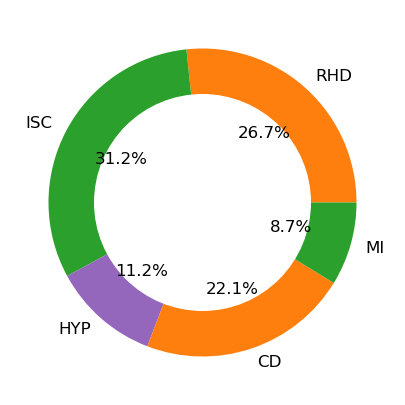

0.0    75
1.0    53
2.0    54
3.0    64
4.0    42
Name: 1838, dtype: int64


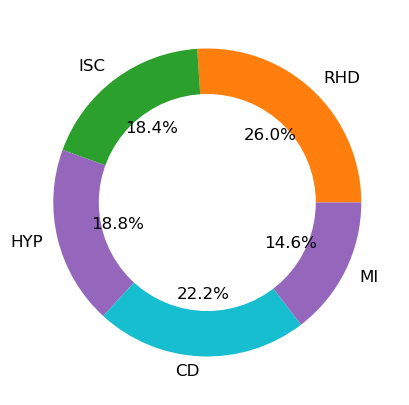

Resampled train Data:  (288, 1792)
Resampled train Labels:  (288,)
Total train data:  (288, 1792, 1)
Total test data:  (77, 1792, 1)
Total train labels:  (288, 5)
Total test labels:  (77, 5)
Total test Subjects:  (77, 2)
(288, 1792, 1) (288, 46)
(60, 1792, 1) (60, 46)
....... Running Fold 1 .....

Epoch 1/60
12/12 [==============================] - 9s 352ms/step - loss: 1.6372 - accuracy: 0.4097 - auc_4: 0.7617 - precision_4: 0.8750 - recall_4: 0.2431 - val_loss: 1.4688 - val_accuracy: 0.4500 - val_auc_4: 0.8284 - val_precision_4: 1.0000 - val_recall_4: 0.3500 - lr: 0.0010
Epoch 2/60
12/12 [==============================] - 3s 236ms/step - loss: 1.4025 - accuracy: 0.5174 - auc_4: 0.8548 - precision_4: 0.9259 - recall_4: 0.2604 - val_loss: 1.3010 - val_accuracy: 0.4333 - val_auc_4: 0.8017 - val_precision_4: 1.0000 - val_recall_4: 0.3167 - lr: 0.0010
Epoch 3/60
12/12 [==============================] - 3s 236ms/step - loss: 1.2264 - accuracy: 0.5347 - auc_4: 0.8665 - precision_4: 0.9560 -

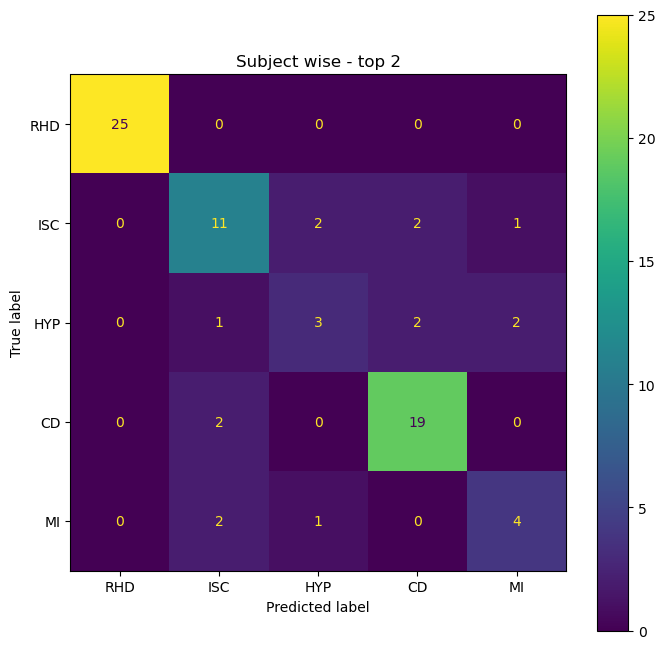

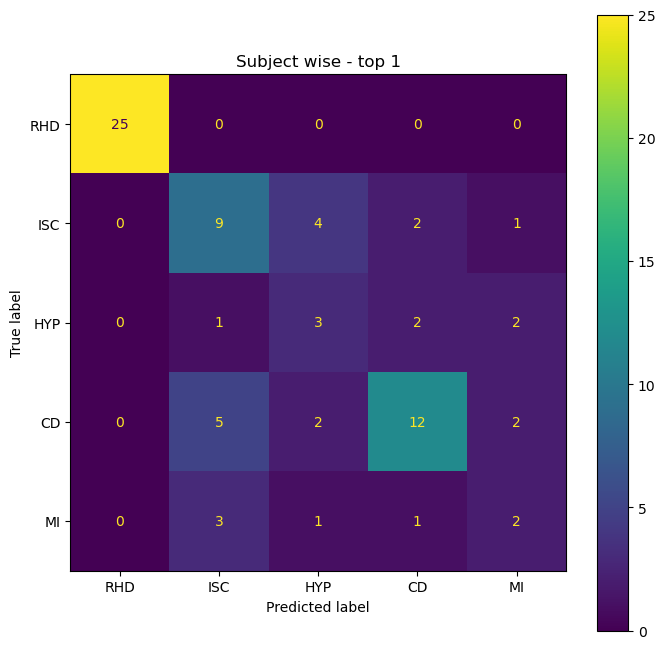


....... Loading rhd-ecg data normal subjects.....
....... Test foldset indices of normal subjects..... 9 [1014, 1002, 1037, 1039, 1033, 1016, 1031, 1027, 1001]

....... Loading rhd-ecg data rhd subjects.....
....... Test foldset indices of rhd subjects..... 24 [10, 66, 24, 48, 60, 59, 40, 94, 57, 97, 75, 54, 69, 45, 118, 30, 120, 47, 51, 5, 9, 1, 43, 112]

....... Loading Other Arrhythimias class data ........


....... Loading Other Arrhythimias class data ........

....... Test foldset indices of others subjects..... [17, 31, 11, 30, 7, 34, 26, 20]
....... Test foldset indices of others subjects..... [94, 29, 31, 11, 77, 97, 5, 45, 26, 28, 9, 22, 52, 40, 75, 74, 102, 70, 39, 65, 86]
class_weights:  [0.62061856 0.95555556 1.88125    0.73414634 2.22962963]
Data:  (240, 1792)
Labels:  (240, 5)
Data after appending labels (y):  (240, 1839)
2.0    25
1.0    50
3.0    69
0.0    77
4.0    19
Name: 1838, dtype: int64


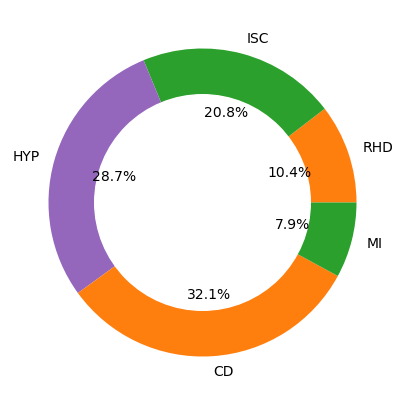

0.0    77
1.0    50
2.0    50
3.0    69
4.0    38
Name: 1838, dtype: int64


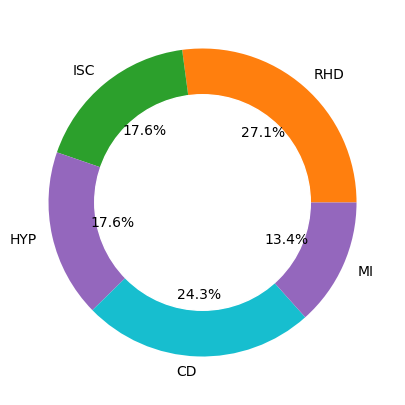

Resampled train Data:  (284, 1792)
Resampled train Labels:  (284,)
Total train data:  (284, 1792, 1)
Total test data:  (76, 1792, 1)
Total train labels:  (284, 5)
Total test labels:  (76, 5)
Total test Subjects:  (76, 2)
(284, 1792, 1) (284, 46)
(61, 1792, 1) (61, 46)
....... Running Fold 2 .....

Epoch 1/60
12/12 [==============================] - 13s 459ms/step - loss: 1.6077 - accuracy: 0.4085 - auc_5: 0.7706 - precision_5: 0.8919 - recall_5: 0.2324 - val_loss: 1.4476 - val_accuracy: 0.4426 - val_auc_5: 0.7952 - val_precision_5: 1.0000 - val_recall_5: 0.3279 - lr: 0.0010
Epoch 2/60
12/12 [==============================] - 3s 239ms/step - loss: 1.3426 - accuracy: 0.5739 - auc_5: 0.8811 - precision_5: 0.9574 - recall_5: 0.3169 - val_loss: 1.2722 - val_accuracy: 0.4590 - val_auc_5: 0.8126 - val_precision_5: 1.0000 - val_recall_5: 0.3279 - lr: 0.0010
Epoch 3/60
12/12 [==============================] - 3s 239ms/step - loss: 1.1660 - accuracy: 0.6690 - auc_5: 0.9132 - precision_5: 0.9643 

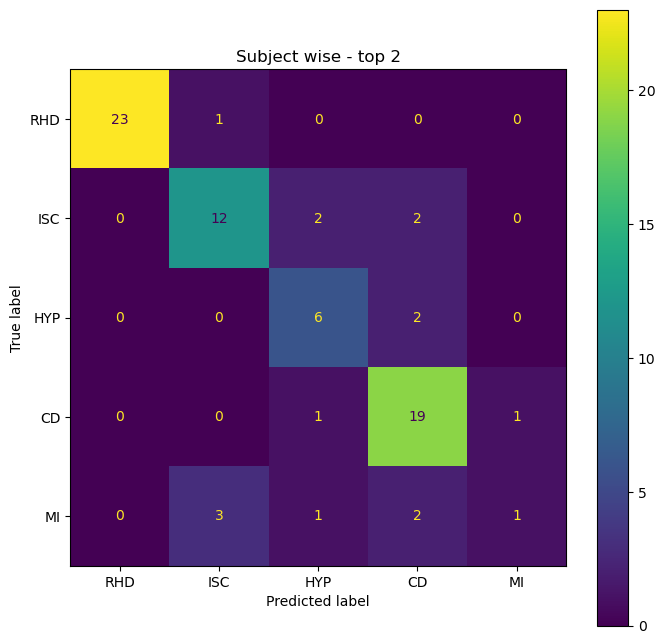

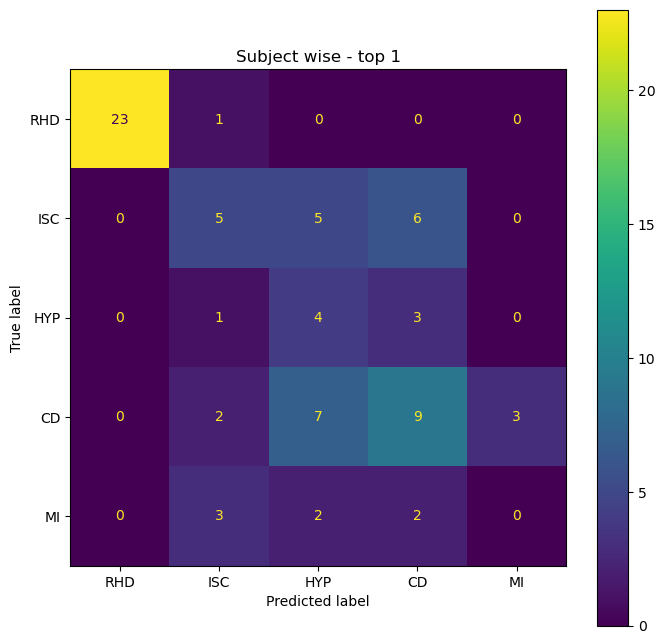


....... Loading rhd-ecg data normal subjects.....
....... Test foldset indices of normal subjects..... 9 [1043, 1010, 1020, 1019, 1004, 1011, 1008, 1030, 1018]

....... Loading rhd-ecg data rhd subjects.....
....... Test foldset indices of rhd subjects..... 24 [8, 64, 65, 71, 100, 89, 22, 77, 29, 20, 23, 82, 52, 91, 74, 21, 87, 121, 90, 26, 93, 37, 50, 32]

....... Loading Other Arrhythimias class data ........


....... Loading Other Arrhythimias class data ........

....... Test foldset indices of others subjects..... [35, 8, 10, 1, 16, 32, 0, 3]
....... Test foldset indices of others subjects..... [72, 67, 7, 2, 30, 66, 42, 98, 84, 82, 61, 93, 50, 14, 17, 80, 6, 85, 56, 32, 64]
class_weights:  [0.62061856 0.95555556 1.88125    0.73414634 2.22962963]
Data:  (240, 1792)
Labels:  (240, 5)
Data after appending labels (y):  (240, 1839)
2.0    25
1.0    50
3.0    69
0.0    77
4.0    19
Name: 1838, dtype: int64


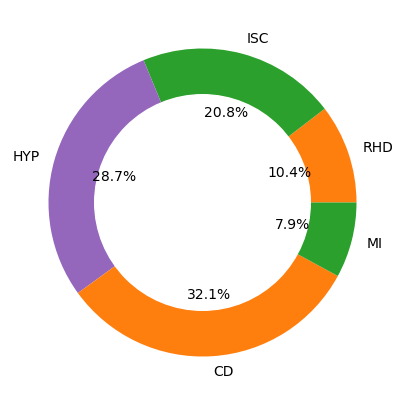

0.0    77
1.0    50
2.0    50
3.0    69
4.0    38
Name: 1838, dtype: int64


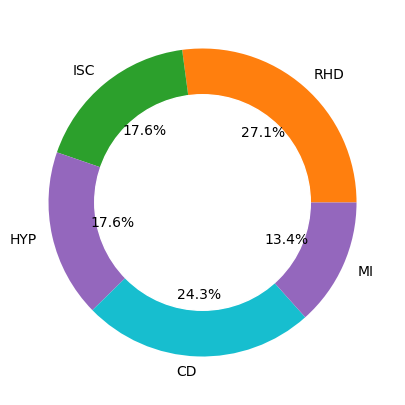

Resampled train Data:  (284, 1792)
Resampled train Labels:  (284,)
Total train data:  (284, 1792, 1)
Total test data:  (76, 1792, 1)
Total train labels:  (284, 5)
Total test labels:  (76, 5)
Total test Subjects:  (76, 2)
(284, 1792, 1) (284, 46)
(61, 1792, 1) (61, 46)
....... Running Fold 3 .....

Epoch 1/60
12/12 [==============================] - 13s 419ms/step - loss: 1.6209 - accuracy: 0.4049 - auc_6: 0.7735 - precision_6: 0.9718 - recall_6: 0.2430 - val_loss: 1.4470 - val_accuracy: 0.4590 - val_auc_6: 0.7997 - val_precision_6: 1.0000 - val_recall_6: 0.3279 - lr: 0.0010
Epoch 2/60
12/12 [==============================] - 3s 240ms/step - loss: 1.3505 - accuracy: 0.5634 - auc_6: 0.8702 - precision_6: 1.0000 - recall_6: 0.2817 - val_loss: 1.2483 - val_accuracy: 0.4426 - val_auc_6: 0.8154 - val_precision_6: 1.0000 - val_recall_6: 0.3115 - lr: 0.0010
Epoch 3/60
12/12 [==============================] - 3s 237ms/step - loss: 1.1702 - accuracy: 0.5951 - auc_6: 0.8809 - precision_6: 0.9775 

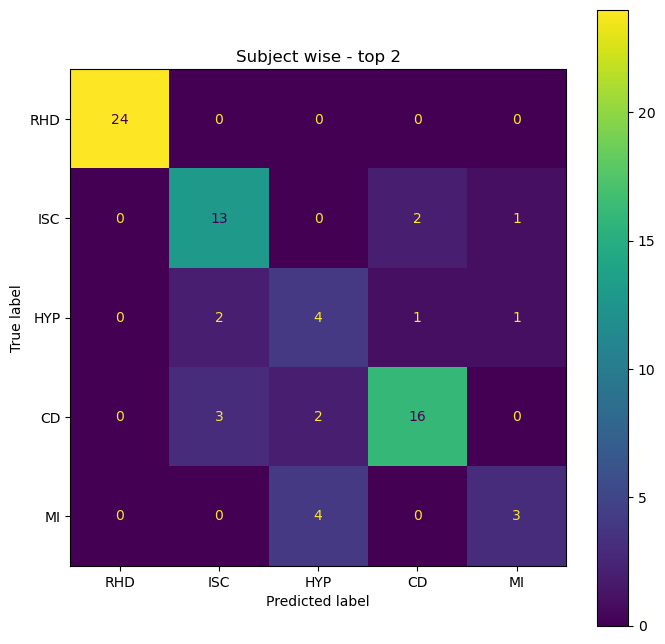

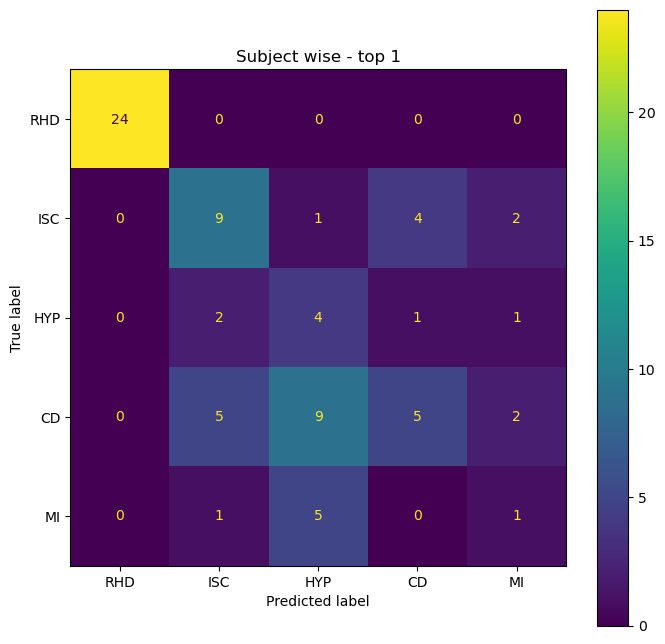


....... Loading rhd-ecg data normal subjects.....
....... Test foldset indices of normal subjects..... 9 [1022, 1012, 1005, 1034, 1006, 1042, 1026, 1035, 1007]

....... Loading rhd-ecg data rhd subjects.....
....... Test foldset indices of rhd subjects..... 24 [13, 39, 107, 11, 84, 28, 31, 27, 58, 108, 103, 79, 35, 81, 86, 98, 7, 56, 114, 16, 42, 36, 61, 34]

....... Loading Other Arrhythimias class data ........


....... Loading Other Arrhythimias class data ........

....... Test foldset indices of others subjects..... [22, 2, 15, 28, 29, 36, 4, 6]
....... Test foldset indices of others subjects..... [96, 49, 33, 78, 69, 51, 100, 95, 90, 43, 81, 101, 53, 88, 83, 54, 48, 37, 87, 41]
class_weights:  [0.62268041 0.95873016 1.8875     0.72771084 2.23703704]
Data:  (241, 1792)
Labels:  (241, 5)
Data after appending labels (y):  (241, 1839)
1.0    51
3.0    65
0.0    77
2.0    28
4.0    20
Name: 1838, dtype: int64


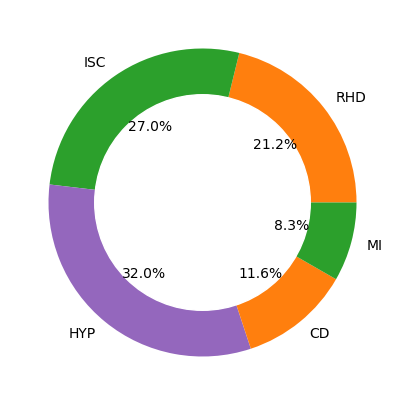

0.0    77
1.0    51
2.0    56
3.0    65
4.0    40
Name: 1838, dtype: int64


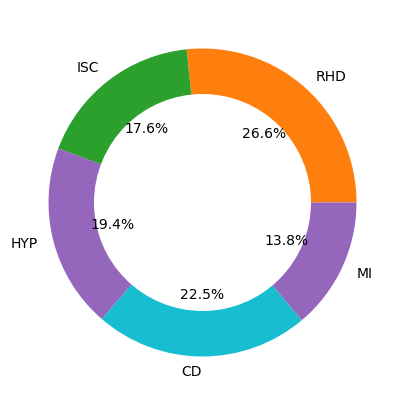

Resampled train Data:  (289, 1792)
Resampled train Labels:  (289,)
Total train data:  (289, 1792, 1)
Total test data:  (75, 1792, 1)
Total train labels:  (289, 5)
Total test labels:  (75, 5)
Total test Subjects:  (75, 2)
(289, 1792, 1) (289, 46)
(61, 1792, 1) (61, 46)
....... Running Fold 4 .....

Epoch 1/60
13/13 [==============================] - 13s 403ms/step - loss: 1.6350 - accuracy: 0.4498 - auc_7: 0.7628 - precision_7: 0.9565 - recall_7: 0.2284 - val_loss: 1.4506 - val_accuracy: 0.3607 - val_auc_7: 0.7652 - val_precision_7: 1.0000 - val_recall_7: 0.2951 - lr: 0.0010
Epoch 2/60
13/13 [==============================] - 3s 223ms/step - loss: 1.4029 - accuracy: 0.4221 - auc_7: 0.7630 - precision_7: 0.8654 - recall_7: 0.1557 - val_loss: 1.3083 - val_accuracy: 0.3934 - val_auc_7: 0.7757 - val_precision_7: 1.0000 - val_recall_7: 0.3115 - lr: 0.0010
Epoch 3/60
13/13 [==============================] - 3s 222ms/step - loss: 1.2358 - accuracy: 0.6540 - auc_7: 0.8895 - precision_7: 0.9634 

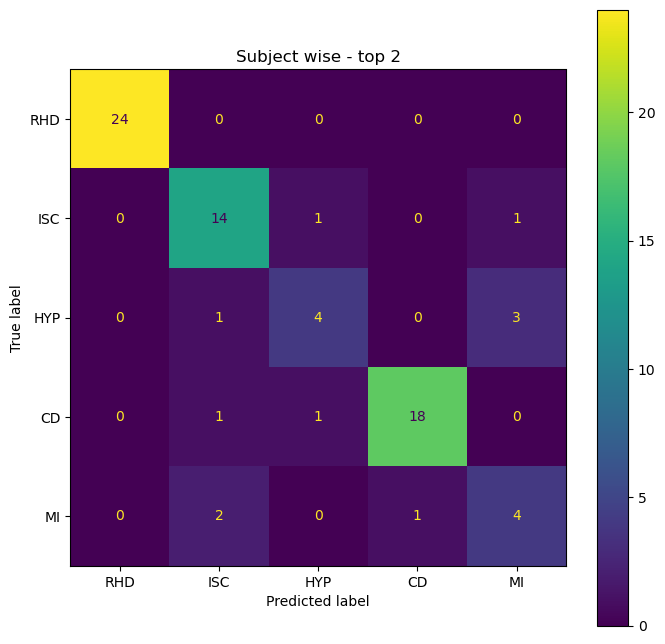

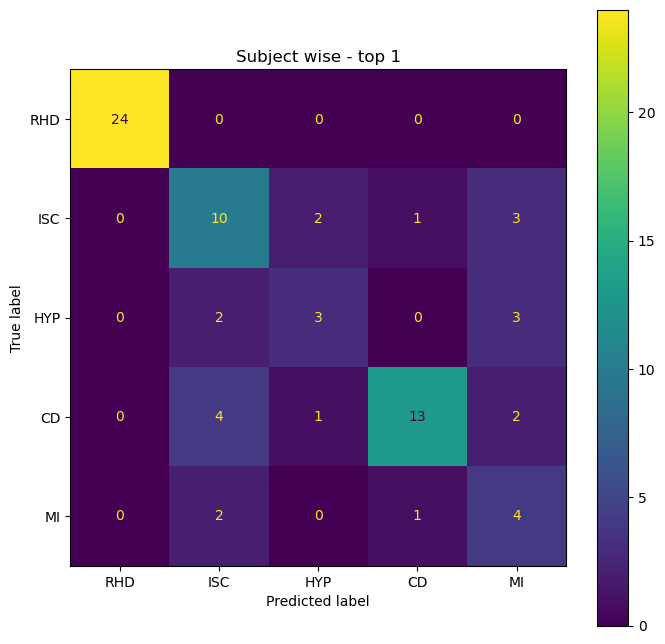


....... Loading rhd-ecg data normal subjects.....
....... Test foldset indices of normal subjects..... 9 [1013, 1029, 1028, 1023, 1038, 1015, 1024, 1041, 1017]

....... Loading rhd-ecg data rhd subjects.....
....... Test foldset indices of rhd subjects..... 24 [14, 96, 15, 49, 76, 119, 44, 106, 102, 104, 83, 38, 17, 80, 67, 111, 116, 113, 55, 88, 3, 101, 25, 105]

....... Loading Other Arrhythimias class data ........


....... Loading Other Arrhythimias class data ........

....... Test foldset indices of others subjects..... [37, 38, 21, 18, 9, 25, 14, 5]
....... Test foldset indices of others subjects..... [8, 89, 10, 44, 46, 25, 24, 35, 68, 23, 38, 0, 63, 71, 62, 19, 60, 16, 99, 34]
class_weights:  [0.62680412 0.95       1.9        0.73253012 2.17142857]
Data:  (243, 1792)
Labels:  (243, 5)
Data after appending labels (y):  (243, 1839)
3.0    67
0.0    77
2.0    28
1.0    51
4.0    20
Name: 1838, dtype: int64


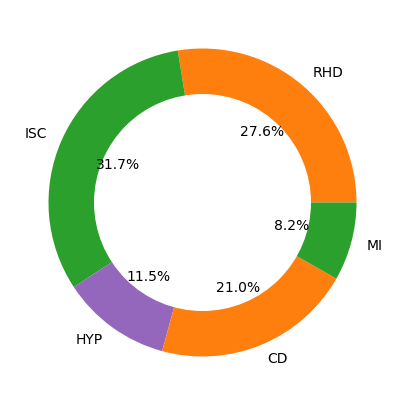

0.0    77
1.0    51
2.0    56
3.0    67
4.0    40
Name: 1838, dtype: int64


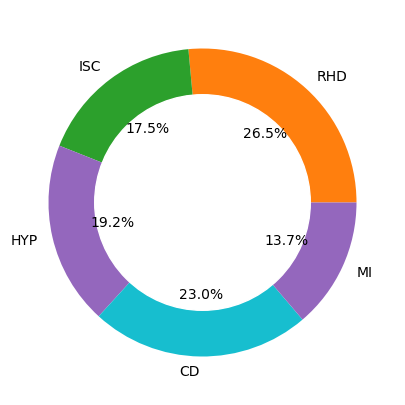

Resampled train Data:  (291, 1792)
Resampled train Labels:  (291,)
Total train data:  (291, 1792, 1)
Total test data:  (73, 1792, 1)
Total train labels:  (291, 5)
Total test labels:  (73, 5)
Total test Subjects:  (73, 2)
(291, 1792, 1) (291, 46)
(61, 1792, 1) (61, 46)
....... Running Fold 5 .....

Epoch 1/60
13/13 [==============================] - 11s 418ms/step - loss: 1.6258 - accuracy: 0.4674 - auc_8: 0.7774 - precision_8: 0.9552 - recall_8: 0.2199 - val_loss: 1.4678 - val_accuracy: 0.3934 - val_auc_8: 0.7905 - val_precision_8: 1.0000 - val_recall_8: 0.3279 - lr: 0.0010
Epoch 2/60
13/13 [==============================] - 3s 224ms/step - loss: 1.4942 - accuracy: 0.3471 - auc_8: 0.6860 - precision_8: 0.4675 - recall_8: 0.1237 - val_loss: 1.3032 - val_accuracy: 0.4918 - val_auc_8: 0.8256 - val_precision_8: 1.0000 - val_recall_8: 0.3115 - lr: 0.0010
Epoch 3/60
13/13 [==============================] - 3s 225ms/step - loss: 1.2624 - accuracy: 0.5636 - auc_8: 0.8792 - precision_8: 1.0000 

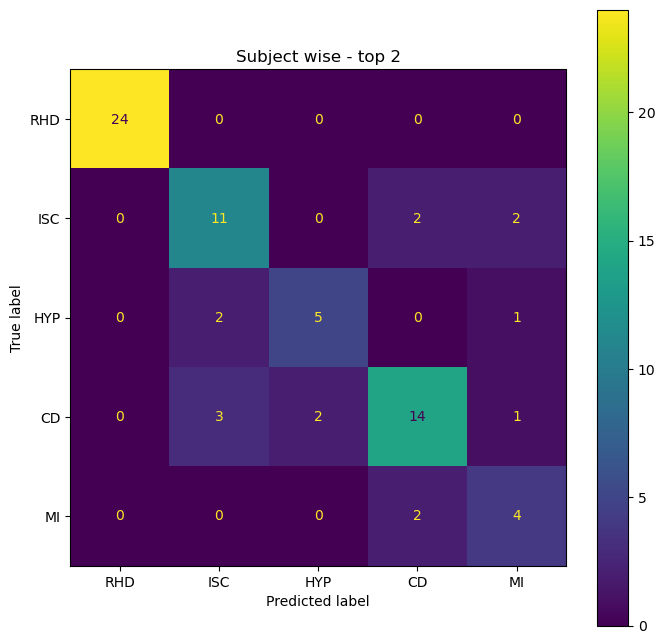

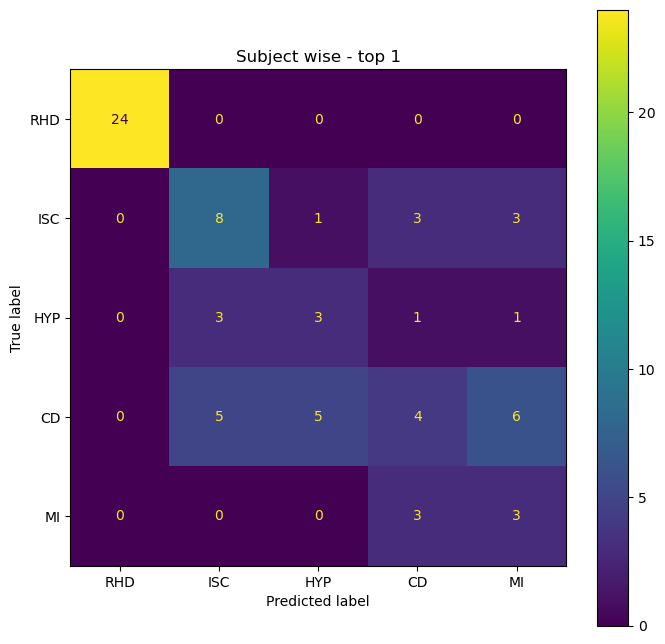

------------------------------------------------------------------------
Merged dataset Score per fold (subjects) top-1
------------------------------------------------------------------------
> Fold 1 - F1: 0.556 - Precision: 0.558 - Recall: 0.559
------------------------------------------------------------------------
> Fold 2 - F1: 0.417 - Precision: 0.418 - Recall: 0.44
------------------------------------------------------------------------
> Fold 3 - F1: 0.464 - Precision: 0.481 - Recall: 0.489
------------------------------------------------------------------------
> Fold 4 - F1: 0.636 - Precision: 0.651 - Recall: 0.644
------------------------------------------------------------------------
> Fold 5 - F1: 0.489 - Precision: 0.486 - Recall: 0.522
------------------------------------------------------------------------
------------------------------------------------------------------------
Merged dataset Score per fold (subjects) top-2
-------------------------------------------

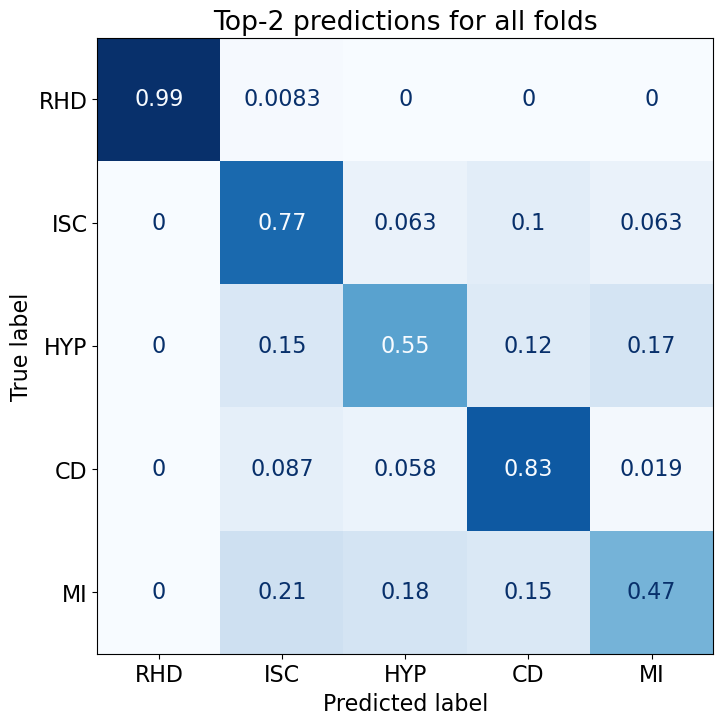

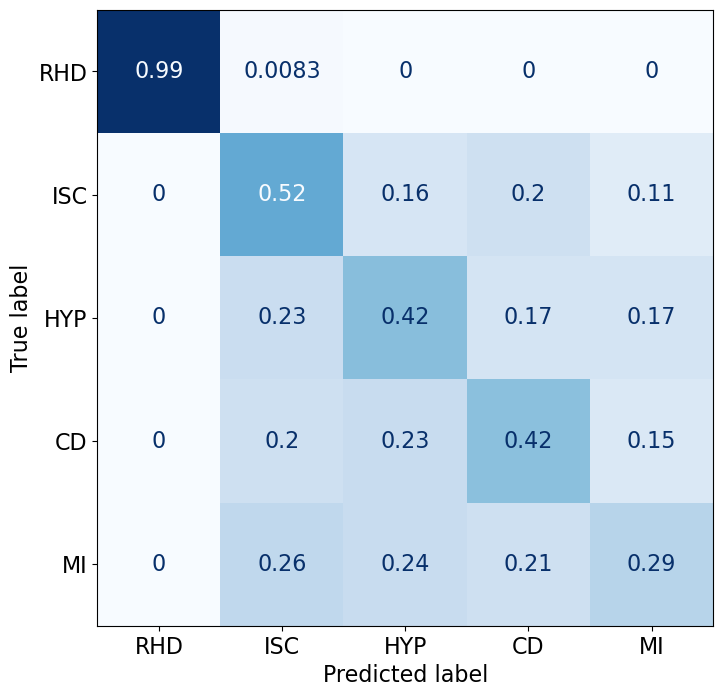

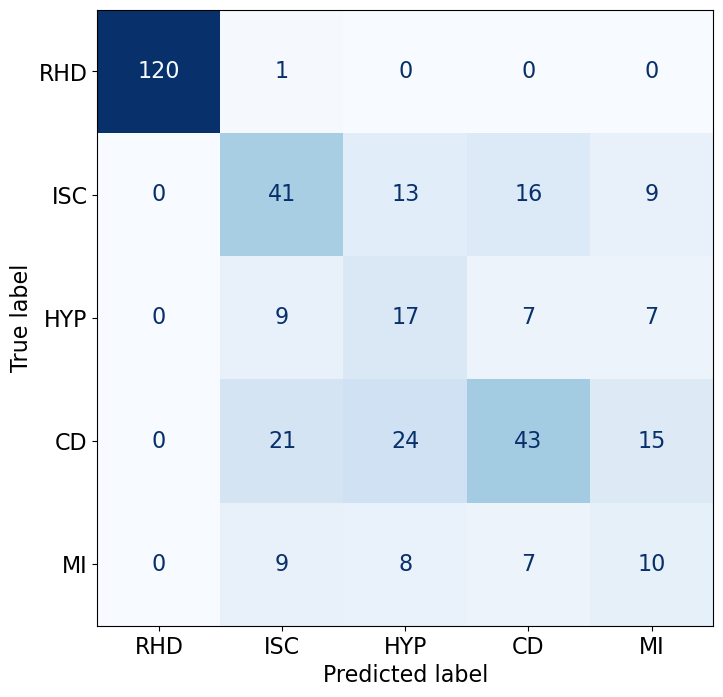

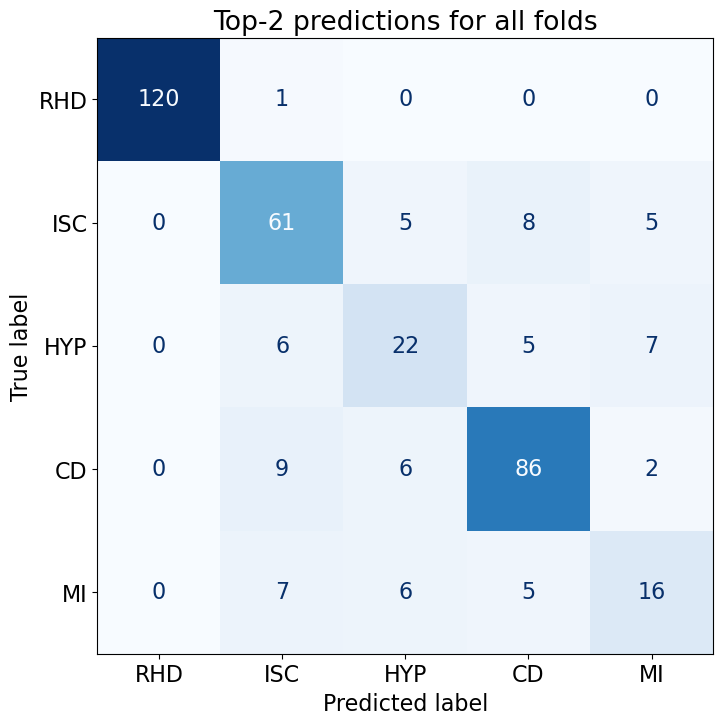

In [53]:
#### 5-folds
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
# Load all Dataset
#######################################################
plt.figure(dpi=150)
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [6,6]

########### Initialize variables ##############
BATCH_SIZE = 24#20
EPOCHS = 60

f1_fold_rhd2 = []
precision_fold_rhd2 = []
recall_fold_rhd2 = []
acc_fold_rhd2 = []
f1_fold_rhd = []
f1_fold_rhd = []
auc_fold = []                      

precision_fold_rhd = []
recall_fold_rhd = []
acc_fold_rhd = []
f1_fold2 = []
precision_fold2 = []
recall_fold2 = []
specificity_fold =[]
specificity_fold2 =[]
acc_fold2 = []
auc_fold2 = []
cm_fold = 0
cm_slice = 0 
cm_rhdonly=0
cm_slice=0
cm_all=0 
y_top_k_all=0
ytrues=[]
ypreds=[]
n_classes=5
########### Load RHD_ECG data for each fold #################
filelist_normal, file_indx_list_normal, idx_folds_normal = load_data('normal')
filelist_rhd, file_indx_list_rhd, idx_folds_rhd = load_data('rhd')   
path = 'C:/Users/u0143922/OneDrive - KU Leuven/Experiments/RHDECG/Data/'
metafeat_rhdecg=pd.read_excel(path+'features6Cls_rhdecg3.xlsx')
metafeat_ptb=pd.read_excel(path+'features6Cls_ptb2.xlsx')

# metafeat_rhdecg.drop(['RWE_D1','RWE_A8','HRV_MinNN','HRV_MaxNN','HRV_MeanNN','HRV_SDNN','HRV_CVNN',
#                    'HRV_MedianNN','HRV_MCVNN','HRV_IQRNN','HRV_Prc80NN','HRV_HTI','HRV_TINN','HRV_MCVNN',
#                   'ST','P_on_R','RP_peak','PP_RR','P_ratio','PT','PP'],axis=1)

# metafeat_ptb.drop(['RWE_D1','RWE_A8','HRV_MinNN','HRV_MaxNN','HRV_MeanNN','HRV_SDNN','HRV_CVNN',
#                    'HRV_MedianNN','HRV_MCVNN','HRV_IQRNN','HRV_Prc80NN','HRV_HTI','HRV_TINN','HRV_MCVNN',
#                   'ST','P_on_R','RP_peak','PP_RR','P_ratio','PT','PP'],axis=1)

# metafeat_rhdecg.drop(['HRV_MinNN','HRV_MaxNN','ST','P_on_R','RP_peak','PP_RR','P_ratio','PT','PP'],axis=1)
# metafeat_ptb.drop(['HRV_MinNN','HRV_MaxNN','ST','P_on_R','RP_peak','PP_RR','P_ratio','PT','PP'],axis=1)

########## Fit the model for each fold ######################
for fold_num in range(num_fold_NSR):      
    
    # Load dataset from RHDECG
    X_train_tash_normal, y_train_tash_normal, X_test_tash_normal, y_test_tash_normal,idx_test_normal,rec_list_normal,metafeat_trainX_normal,metafeat_testX_normal = load_data_kfold(fold_num,250,'normal',metafeat=metafeat_rhdecg)
    X_train_tash_rhd, y_train_tash_rhd, X_test_tash_rhd, y_test_tash_rhd,idx_test_rhd,rec_list_rhd, metafeat_trainX_rhd,metafeat_testX_rhd = load_data_kfold(fold_num,250,'rhd',metafeat=metafeat_rhdecg)    
#   # Normalization done per record during data cleaning

    #Merge randomly selected PTBNSR records with RHDECG 
    X_train_normal_ptb, y_train_normal_ptb, X_test_normal_ptb, y_test_normal_ptb,idx_test_normal_ptb,rec_list_normal_ptb, metafeat_trainX_nsrptb,metafeat_testX_nsrptb = load_NSR_kfold(fold_num,250,idx_NSR, folds_NSR,metafeat=metafeat_ptb)
    rhdecg_trainX = np.vstack((X_train_tash_normal,X_train_normal_ptb,X_train_tash_rhd))
    rhdecg_trainY = np.hstack((np.zeros(X_train_tash_normal.shape[0]+X_train_normal_ptb.shape[0]),np.ones(X_train_tash_rhd.shape[0]))) 
    rhdecg_testX = np.vstack((X_test_tash_normal,X_test_normal_ptb,X_test_tash_rhd))
    rhdecg_testY = np.hstack((np.zeros(X_test_tash_normal.shape[0]+X_test_normal_ptb.shape[0]),np.ones(X_test_tash_rhd.shape[0])))   
    rhdecg_rec_list = np.vstack((rec_list_normal,rec_list_normal_ptb,rec_list_rhd))

    # Load additional dataset from PTB_XL
#     X_train_afib, y_train_afib, X_test_afib, y_test_afib,idx_test_afib,rec_list_afib = load_afib_kfold(fold_num,250,idx_Afib, folds_Afib)
    X_train_STTC, y_train_STTC, X_test_STTC, y_test_STTC,idx_test_STTC,rec_list_STTC, metafeat_trainX_sttc,metafeat_testX_sttc = load_STTC_kfold(fold_num,250,idx_STTC, folds_STTC,metafeat=metafeat_ptb)
    X_train_HYP, y_train_HYP, X_test_HYP, y_test_HYP,idx_test_HYP,rec_list_HYP, metafeat_trainX_hyp,metafeat_testX_hyp = load_HYP_kfold(fold_num,250,idx_HYP, folds_HYP,metafeat=metafeat_ptb)
    X_train_CD, y_train_CD, X_test_CD, y_test_CD,idx_test_CD,rec_list_CD, metafeat_trainX_cd,metafeat_testX_cd = load_CD_kfold(fold_num,250,idx_CD, folds_CD,metafeat=metafeat_ptb)
    X_train_MI, y_train_MI, X_test_MI, y_test_MI,idx_test_MI,rec_list_MI, metafeat_trainX_mi,metafeat_testX_mi = load_MI_kfold(fold_num,250,idx_MI, folds_MI,metafeat=metafeat_ptb)

    ########### Add additional Datasets
#     X_train_ext = np.vstack((X_train_normals,X_train_normals*-1,rhdecg_trainX,rhdecg_trainX*-1,X_train_STTC,X_train_STTC*-1,
#                              X_train_HYP,X_train_HYP*-1,X_train_CD,X_train_CD*-1,X_train_MI,X_train_MI*-1))
#     y_train_ext = np.hstack((y_train_normals,y_train_normals,rhdecg_trainY,rhdecg_trainY,y_train_STTC,y_train_STTC,
#                              y_train_HYP,y_train_HYP,y_train_CD,y_train_CD,y_train_MI,y_train_MI))
#     X_train_ext = np.vstack((X_train_tash_normal,X_train_normal_ptb,X_train_tash_rhd,X_train_STTC,X_train_HYP,X_train_CD,X_train_MI))
#     y_train_ext = np.hstack((y_train_tash_normal,y_train_normal_ptb,y_train_tash_rhd,y_train_STTC,y_train_HYP,y_train_CD,y_train_MI))

    #### for rebuttal
    X_train_ext = np.vstack((X_train_tash_rhd,X_train_STTC,X_train_HYP,X_train_CD,X_train_MI))
    y_train_ext = np.hstack((y_train_tash_rhd,y_train_STTC,y_train_HYP,y_train_CD,y_train_MI))

    
    X_test_ext = np.vstack((X_test_tash_rhd,X_test_STTC,X_test_HYP,X_test_CD,X_test_MI))
    y_test_ext = np.hstack((y_test_tash_rhd,y_test_STTC,y_test_HYP,y_test_CD,y_test_MI))   
    rec_list_ext = np.vstack((rec_list_rhd,rec_list_STTC,rec_list_HYP,rec_list_CD,rec_list_MI))

    X_train_ext=X_train_ext[:,:2048] #2048
    X_test_ext=X_test_ext[:,:2048]
    
    metafeat_trainX = np.vstack((metafeat_trainX_rhd,metafeat_trainX_sttc,metafeat_trainX_hyp,metafeat_trainX_cd,metafeat_trainX_mi))
    metafeat_testX = np.vstack((metafeat_testX_rhd,metafeat_testX_sttc,metafeat_testX_hyp,metafeat_testX_cd,metafeat_testX_mi))
    metafeat_trainX = metafeat_trainX[:,:-1]
    metafeat_testX = metafeat_testX[:,:-1]
#     print(metafeat_trainX_normal.shape, X_train_tash_normal.shape)
#     print(metafeat_trainX_nsrptb.shape, X_train_normal_ptb.shape)
#     print(metafeat_trainX_rhd.shape, X_train_tash_rhd.shape)
#     print(metafeat_trainX_sttc.shape, X_train_STTC.shape)
#     print(metafeat_trainX_hyp.shape, X_train_HYP.shape)
#     print(metafeat_trainX_cd.shape, X_train_CD.shape)
#     print(metafeat_trainX_mi.shape, X_train_MI.shape)
    ##########################################################################################
    ########## Data rearranged => One-hot encoding => Z-transform
    indices = range(len(X_train_ext))
    X_train, y_train, X_test, y_test, class_weights = prep.generate_data(X_train_ext,X_test_ext,y_train_ext,y_test_ext)
    X_train_ext, X_val, y_train_ext, y_val,indices_train,indices_val = train_test_split(X_train, y_train.astype(int), indices, test_size=0.2, random_state=42)
    metafeat_train=metafeat_trainX[indices_train] #remove class label
    metafeat_val=metafeat_trainX[indices_val]
    metafeat_testX = metafeat_testX

    ##########################################################################################
    # Resampling dataset
    # Show Before resampling
    print('Data: ',X_train_ext.shape)
    print('Labels: ',y_train_ext.shape)
    X_train_ext=np.hstack((X_train_ext,metafeat_train))
    y_trn=np.array(np.argmax(y_train_ext,axis=1))
    X_tobe_sampled=X_train_ext.tolist()
    for i in range(0,len(X_train_ext)):
            X_tobe_sampled[i] = np.append(X_train_ext[i], y_trn[i])
    print('Data after appending labels (y): ',np.shape(X_tobe_sampled))
    #plt.rcParams.update({'font.size': 10})
    X_train_df = pd.DataFrame(X_tobe_sampled)
    per_class = X_train_df[X_train_df.shape[1]-1].value_counts(sort=False)
    print(per_class)
    plt.figure(figsize=(20,5))
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    plt.pie(per_class, labels=['RHD','ISC','HYP', 'CD','MI'], colors=['tab:orange','tab:green','tab:purple'],autopct='%1.1f%%')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

    #Now Resample dataset and show
    
    df_0=X_train_df[X_train_df[X_train_df.shape[1]-1]==0]
    df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
    df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
    df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
    df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
#     df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
#     df_7=X_train_df[X_train_df[X_train_df.shape[1]-1]==7]
    # nsr, rhd, sttc, hyp, cd, mi
    df_0_downsample=resample(df_0,replace=False,n_samples=int(per_class[0]),random_state=129) #145
    df_1_upsample=resample(df_1,replace=False,n_samples=int(per_class[1]*1),random_state=41) #121, replace=false
    df_2_upsample=resample(df_2,replace=True,n_samples=int(int(per_class[2]*2)),random_state=123)#136
    df_3_upsample=resample(df_3,replace=False,n_samples=int(int(per_class[3]*1)),random_state=141)#*129
    df_4_upsample=resample(df_4,replace=True,n_samples=int(int(per_class[4]*2)),random_state=125) #163
#     df_5_upsample=resample(df_5,replace=True,n_samples=int(int(per_class[2]*3)),random_state=143) #129
    
    X_train_df=pd.concat([df_0_downsample,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])
    per_class = X_train_df[X_train_df.shape[1]-1].value_counts(sort=False)
    print(per_class)
    plt.figure(figsize=(20,5))
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    plt.pie(per_class, labels=['RHD','ISC','HYP', 'CD','MI'], 
            colors=['tab:orange','tab:green','tab:purple', 'tab:cyan','tab:purple'],autopct='%1.1f%%')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

    y_train_df=np.array([X_train_df.iloc[:,-1]], dtype=int).reshape(-1)
    metafeat_train=np.array(X_train_df)[:,:-1];

    metafeat_train=metafeat_train[:,-metafeat_trainX.shape[1]:]
    X_train_df=np.array(X_train_df)[:,:X_test_ext.shape[1]]
    print('Resampled train Data: ',X_train_df.shape)
    print('Resampled train Labels: ',y_train_df.shape)
    ######################################################################################################3



    ######## Add channel index => (Samples X Length X 1 )
    X_train = np.expand_dims(X_train_df,axis=2)
    X_val = np.expand_dims(X_val,axis=2)
    X_test = np.expand_dims(X_test,axis=2)
    
    y_train = y_train_df
    y_train = pd.get_dummies(y_train).to_numpy()
#     y_test = pd.get_dummies(y_test).to_numpy()
    
    

    print('Total train data: ', X_train.shape)
    print('Total test data: ', X_test.shape)
    print('Total train labels: ', y_train.shape )
    print('Total test labels: ', y_test.shape) 
    print('Total test Subjects: ', rec_list_ext.shape)
    
    ################### Initialize the model and params ###############
#     model_cnn = Attn_CNN(ecg_len=X_train.shape[1], num_channel = 1, num_heads=5, mlp_dim=64, embed_dim=64, patch_size=32,num_classes=6, dim_metafeats=metafeat_train.shape[-1])
#     model_cnn = wavelet_cnn((X_train.shape[1],1), num_classes=6, wave_kern='haar', baselev=3, ks=25, convrep=4, wavelet=True)
#     model_cnn = create_model_resnet((X_train.shape[1],1), num_classes=6) 
#     model_cnn = Attn_inception(ecg_len=X_train.shape[1], num_channel = 1, num_classes=6) 
#     model_cnn = Attn_inception_fusion(ecg_len=X_train.shape[1], temporal_feats=None, num_channel = 1, num_classes=6, dim_metafeats=metafeat_train.shape[-1])

#     model_cnn = model_inceptionTime(input_shape=(X_train.shape[1],1), depth=4, num_classes=6, ks=17, nb_epochs=EPOCHS, num_channel = 1, num_heads=3, mlp_dim=32, embed_dim=32, patch_size=64, dim_metafeats=metafeat_train.shape[-1])
#     model_cnn = build_tcn_inception_model(input_length=X_train.shape[1])
    print(X_train.shape,metafeat_train.shape)
    print(X_val.shape,metafeat_val.shape)
    
    model_cnn = build_model(input_shape=(X_train.shape[1],1),num_classes=5,depth=6,use_bottleneck=True,
                            bottleneck_size=True,nb_filters=32,kernel_size=11,num_heads=5,mlp_dim=64,dim_metafeats=46,
                            tcn_kernel_size=7,tcn_dilations=[1, 3, 5], l2_reg=0.001, dropout_rate=0.2)
    
    opt=tf.keras.optimizers.Adam()
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    model_cnn.compile(optimizer=opt, loss=categorical_focal_loss(), metrics=['accuracy',keras.metrics.AUC(),
                      keras.metrics.Precision(),keras.metrics.Recall()])#, tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')])
#     metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')])


    print(f"....... Running Fold {fold_num+1} .....\n" )
    weight_dict = dict()
    for index,value in enumerate(class_weights):
        weight_dict[index] = value 
    history = model_cnn.fit([X_train,metafeat_train],
                            tf.cast(y_train, tf.float32),
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            shuffle=True,
                            validation_data=([X_val,metafeat_val],tf.cast(y_val, tf.float32)),
                            class_weight = weight_dict,
                            callbacks = callbacks_list,
                            verbose=1)

         # Per-Subject prediction
    yt_all,yp_all,yt_rhdecg,yp_rhdecg = eval_multi_topk_fold(model_cnn, [X_test,metafeat_testX], rec_list_ext,y_test)
    print('Top-2 results per subject:\n',classification_report(yt_all,yp_all))
#     yt_all2,yp_all2,_,_ = eval_multi_fold(model_cnn, [X_test,metafeat_testX], rec_list_ext,y_test)
#     print(classification_report(yt_all2,yp_all2))
    yt_all1,yp_all1,_,_ = eval_multi_fold(model_cnn, [X_test,metafeat_testX], rec_list_ext,y_test)
    print('Top-1 results per subject:\n',classification_report(yt_all1,yp_all1))
#     print(classification_report(yt_rhdecg,yp_rhdecg))

    plt.rcParams.update({'font.size': 10})
    plt.rcParams['figure.figsize'] = [8,8]

    # Per-slice prediction
    pred = model_cnn.predict([X_test,metafeat_testX])

    y_pred = np.argmax(pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    best_thresholds = np.zeros(n_classes)
    best_scores = np.zeros(n_classes)

    for class_idx in range(n_classes):
        y_prob = pred[:, class_idx]
        best_f1 = 0
        best_threshold = 0.0

        for threshold in np.arange(0.1, 0.9, 0.01):
            y_pred = (y_prob >= threshold).astype(int)
            f1_temp = roc_auc_score(y_true_bin[:, class_idx], y_pred)

            if f1_temp > best_f1:
                best_f1 = f1_temp
                best_threshold = threshold

        best_thresholds[class_idx] = best_threshold
        best_scores[class_idx] = best_f1

    # Apply thresholds to get final predictions
    y_pred_bin = np.zeros_like(pred)
    for class_idx in range(n_classes):
        y_pred_bin[:, class_idx] = (pred[:, class_idx] >= best_thresholds[class_idx]).astype(int)

    # Convert binary predictions back to class labels (argmax over thresholded outputs)
    y_pred = y_pred_bin.argmax(axis=1)

    # Optional: ROC AUC
    roc_aucs = roc_auc_score(y_true_bin, pred, average='macro', multi_class='ovr')

    # Save for evaluation
    ytrues.append(y_true)
    ypreds.append(y_pred)
    
    #print('Score for all 10s slices',classification_report(y_true, y_pred))
    report2=classification_report(y_true, y_pred,output_dict=True)
    macro_precision2 =  np.round_(report2['macro avg']['precision'] ,decimals=3)
    macro_recall2 = np.round_(report2['macro avg']['recall'] ,decimals=3)   
    macro_f12 = np.round_(report2['macro avg']['f1-score'] ,decimals=3)
    #     print(f'Fold=> {i},  Accuracy:{accuracy} Precision: {macro_precision}  Recall:{macro_recall}   F1:{macro_f1}')


    f1_fold2.append(macro_f12)
    precision_fold2.append(macro_precision2)
    recall_fold2.append(macro_recall2)   
    acc_fold2.append(accuracy_score(y_true, y_pred))   
    
    cm_sl=confusion_matrix(y_true,y_pred)
    cm_slice+=cm_sl

    cm=confusion_matrix(yt_all, yp_all)
    mcm = multilabel_confusion_matrix(yt_all, yp_all)
    tps = mcm[:, 1, 1]
    tns = mcm[:, 0, 0]
    specificity = tns / (tns + mcm[:, 0, 1])         # Specificity
    specificity_fold2.append(np.round_(np.mean(specificity), decimals=3))
    mcm = multilabel_confusion_matrix(yt_all1,yp_all1)
    tps = mcm[:, 1, 1]
    tns = mcm[:, 0, 0]
    specificity = tns / (tns + mcm[:, 0, 1])         # Specificity
    specificity_fold.append(np.round_(np.mean(specificity), decimals=3))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[ 'RHD','ISC','HYP', 'CD','MI'])
    disp.plot()
    plt.title('Subject wise - top 2')
    plt.show()
    cm_all+=cm
    cm=confusion_matrix(yt_all1,yp_all1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[ 'RHD','ISC','HYP', 'CD','MI'])
    disp.plot()
    plt.title('Subject wise - top 1')
    plt.show()
    y_top_k_all+=cm

    report=classification_report(yt_all1,yp_all1,output_dict=True)  
    macro_precision_rhd =  np.round_(report['macro avg']['precision'] ,decimals=3)
    macro_recall_rhd = np.round_(report['macro avg']['recall'] ,decimals=3)   
    macro_f1_rhd = np.round_(report['macro avg']['f1-score'] ,decimals=3)
    f1_fold_rhd.append(macro_f1_rhd)
    precision_fold_rhd.append(macro_precision_rhd)
    recall_fold_rhd.append(macro_recall_rhd)
    acc_fold_rhd.append(accuracy_score(yt_all1,yp_all1))
    auc_fold.append(roc_auc_score(yt_all1,pred, average='macro', multi_class='ovr'))                       

    report=classification_report(yt_all,yp_all,output_dict=True)  
    macro_precision_rhd2 =  np.round_(report['macro avg']['precision'] ,decimals=3)
    macro_recall_rhd2 = np.round_(report['macro avg']['recall'] ,decimals=3)   
    macro_f1_rhd2 = np.round_(report['macro avg']['f1-score'] ,decimals=3)
    f1_fold_rhd2.append(macro_f1_rhd2)
    precision_fold_rhd2.append(macro_precision_rhd2)
    recall_fold_rhd2.append(macro_recall_rhd2)
    acc_fold_rhd2.append(accuracy_score(yt_all,yp_all))
    auc_fold2.append(roc_auc_score(yt_all1,pred, average='macro', multi_class='ovr'))                       
    
#  Provide average scores
print('------------------------------------------------------------------------')
print('Merged dataset Score per fold (subjects) top-1')
for i in range(0, len(f1_fold_rhd)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - F1: {f1_fold_rhd[i]} - Precision: {precision_fold_rhd[i]} - Recall: {recall_fold_rhd[i]}')
print('------------------------------------------------------------------------')
#  Provide average scores
print('------------------------------------------------------------------------')
print('Merged dataset Score per fold (subjects) top-2')
for i in range(0, len(f1_fold_rhd)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - F1: {f1_fold_rhd2[i]} - Precision: {precision_fold_rhd2[i]} - Recall: {recall_fold_rhd2[i]}')
print('------------------------------------------------------------------------')
# print('Merged dataset Score per fold (10s slices)')
# for i in range(0, len(f1_fold2)):
#     print('------------------------------------------------------------------------')
#     print(f'> Fold {i+1} - F1: {f1_fold2[i]} - Precision: {precision_fold2[i]} - Recall: {recall_fold2[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds- Subject wise (TOP-1):')
print(f'> F1: {np.round_(np.mean(f1_fold_rhd),decimals=3)} (+- {np.round_(np.std(f1_fold_rhd),decimals=2)})')
print(f'> Precision: {np.round_(np.mean(precision_fold_rhd),decimals=3)}(+- {np.round_(np.std(precision_fold_rhd),decimals=2)})')
print(f'> Recall: {np.round_(np.mean(recall_fold_rhd),decimals=3)}(+- {np.round_(np.std(recall_fold_rhd),decimals=2)})')
print(f'> Specificity: {np.round_(np.mean(specificity_fold),decimals=3)}(+- {np.round_(np.std(specificity_fold),decimals=2)})')
print(f'> AUC: {np.round_(np.mean(auc_fold),decimals=3)}(+- {np.round_(np.std(auc_fold),decimals=2)})')
print(f'> Accuracy: {np.round_(np.mean(acc_fold_rhd),decimals=3)}(+- {np.round_(np.std(acc_fold_rhd),decimals=2)})')
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('Average scores for all folds- Subject wise (TOP-2):')
print(f'> F1: {np.round_(np.mean(f1_fold_rhd2),decimals=3)} (+- {np.round_(np.std(f1_fold_rhd2),decimals=2)})')
print(f'> Precision: {np.round_(np.mean(precision_fold_rhd2),decimals=3)} (+- {np.round_(np.std(precision_fold_rhd2),decimals=2)})')
print(f'> Recall: {np.round_(np.mean(recall_fold_rhd2),decimals=3)}(+- {np.round_(np.std(recall_fold_rhd2),decimals=2)})')
print(f'> Specificity: {np.round_(np.mean(specificity_fold2),decimals=3)}(+- {np.round_(np.std(specificity_fold2),decimals=2)})')
print(f'> AUC: {np.round_(np.mean(auc_fold2),decimals=3)}(+- {np.round_(np.std(auc_fold2),decimals=2)})')
print(f'> Accuracy: {np.round_(np.mean(acc_fold_rhd2),decimals=3)}(+- {np.round_(np.std(acc_fold_rhd2),decimals=2)})')
print('------------------------------------------------------------------------')

## Plot Collected K-fold conf matrix
# Per-subject all
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [8,8]
cm = cm_all.astype('float') / cm_all.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[ 'RHD','ISC','HYP', 'CD','MI'])
disp.plot(cmap='Blues',colorbar=False)
plt.title('Top-2 predictions for all folds')
plt.show()

cm = y_top_k_all.astype('float') / y_top_k_all.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[ 'RHD','ISC','HYP', 'CD','MI'])
disp.plot(cmap='Blues',colorbar=False)
plt.show()
### UnNormalized cm
disp = ConfusionMatrixDisplay(confusion_matrix=y_top_k_all, display_labels=[ 'RHD','ISC','HYP', 'CD','MI'])
disp.plot(cmap='Blues',colorbar=False)
plt.show()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=[ 'RHD','ISC','HYP', 'CD','MI'])
disp.plot(cmap='Blues',colorbar=False)
plt.title('Top-2 predictions for all folds')
plt.show()

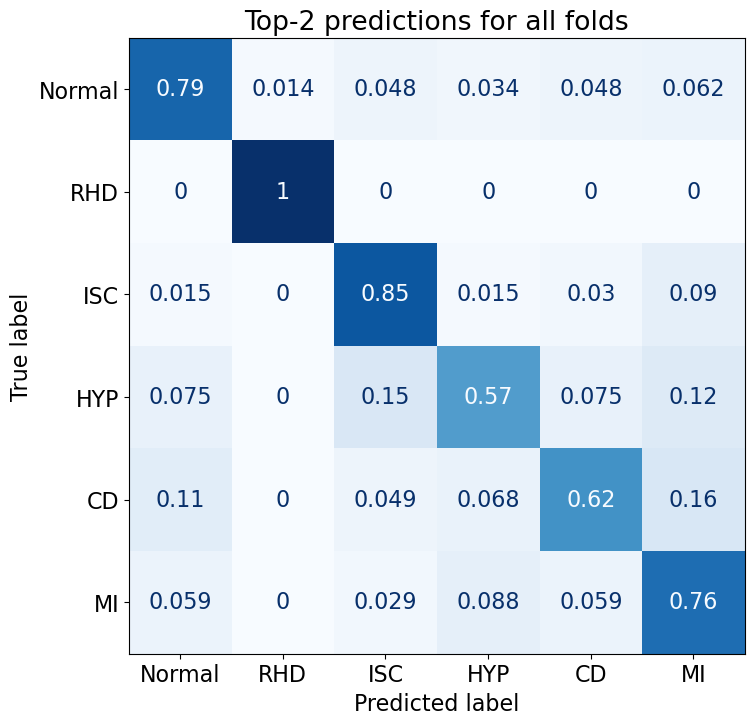

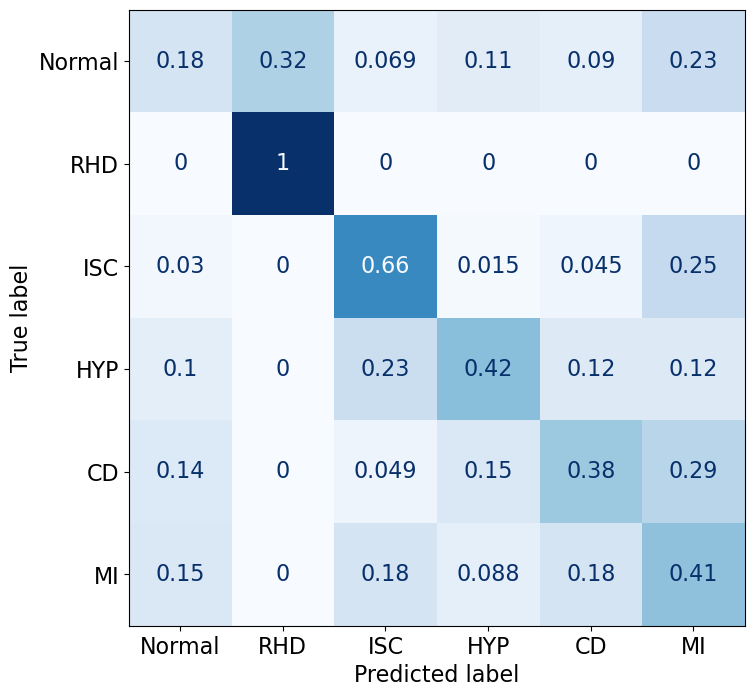

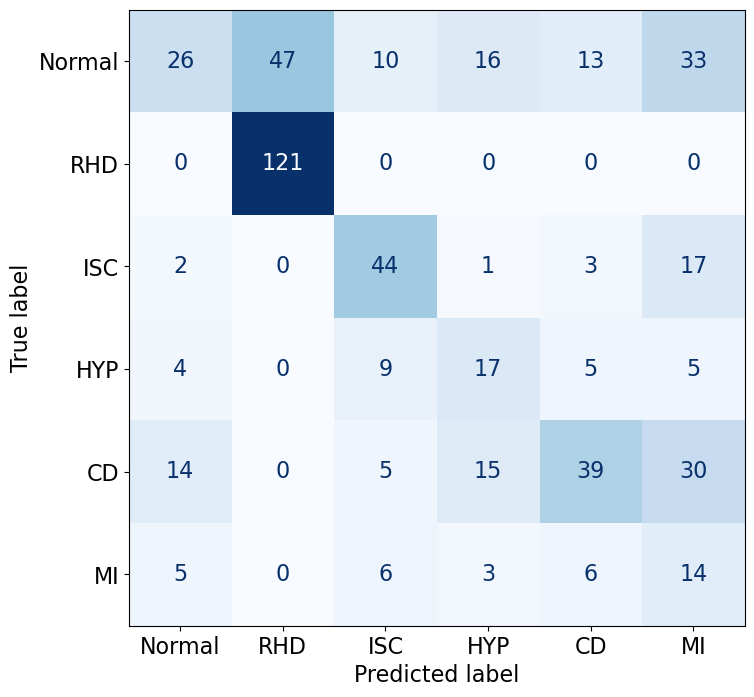

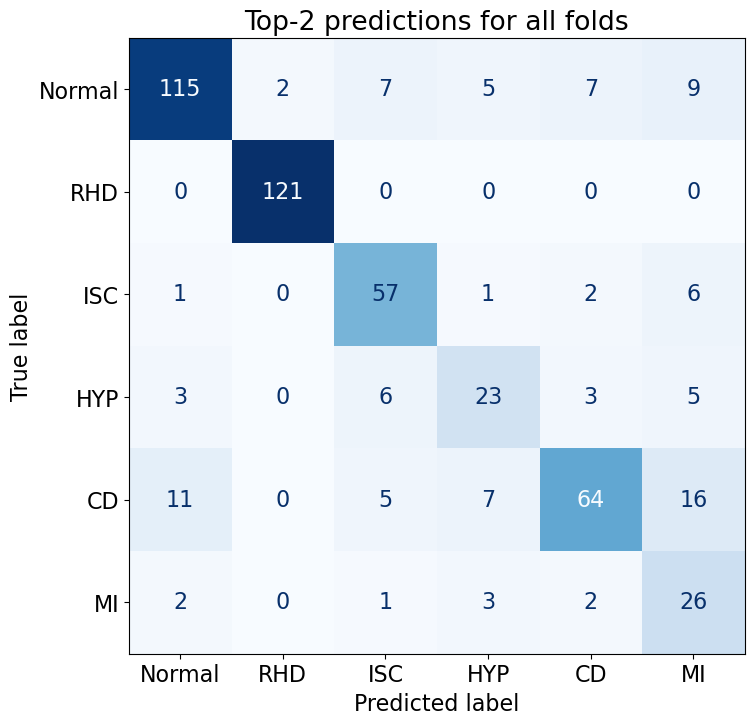

In [43]:
# Per-subject all
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [8,8]
cm = cm_all.astype('float') / cm_all.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'RHD','ISC','HYP', 'CD','MI'])
disp.plot(cmap='Blues',colorbar=False)
plt.title('Top-2 predictions for all folds')
plt.show()

cm = y_top_k_all.astype('float') / y_top_k_all.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'RHD','ISC','HYP', 'CD','MI'])
disp.plot(cmap='Blues',colorbar=False)
plt.show()
### UnNormalized cm
disp = ConfusionMatrixDisplay(confusion_matrix=y_top_k_all, display_labels=['Normal', 'RHD','ISC','HYP', 'CD','MI'])
disp.plot(cmap='Blues',colorbar=False)
plt.show()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=['Normal', 'RHD','ISC','HYP', 'CD','MI'])
disp.plot(cmap='Blues',colorbar=False)
plt.title('Top-2 predictions for all folds')
plt.show()

## Gradient Heatmap Grad-CAM

In [79]:
# Defining the Grad-CAM algorithm
def grad_cam(layer_name, data, model):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    last_conv_layer_output, preds = grad_model(data)
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(data)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0))
    
    last_conv_layer_output = last_conv_layer_output[0]
    
    heatmap = last_conv_layer_output * pooled_grads/2
    heatmap = tf.reduce_mean(heatmap, axis=(1))
    heatmap = np.expand_dims(heatmap,0)
    return heatmap

In [ ]:
def hires_cam(model, input_data, target_layer_name, class_idx=None):
    target_layer = model.get_layer(target_layer_name)
    sub_model = Model(inputs=model.inputs, outputs=[target_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = sub_model(input_data)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    cam = tf.reduce_sum(tf.multiply(grads, conv_outputs), axis=-1).numpy()

    cam = np.maximum(cam, 0)
    cam -= np.min(cam)
    cam /= (np.max(cam) + 1e-8)

    return cam[0]

layer_name = 'conv1d_151'
label = ['Normal', 'RHD']
cnt = 0
fs = 250
duration_sec = 5  # plot first 5 seconds only
samples_to_plot = duration_sec * fs

X_t = np.expand_dims(X_RHD_filt, axis=-1)
y_test = Data_Y[145:].astype(int)

for i in X_t:
    data = np.expand_dims(i, 0)
    pred_array = model_cnn.predict([data])[0]
    pred = np.argmax(pred_array).astype(int)
    print(pred, y_test[cnt])
    
    if pred == y_test[cnt]:
        heatmap = hires_cam(model_cnn, [data], layer_name, class_idx=pred)
        
        print(f"Model prediction = {label[pred]} ({np.round(pred_array, 3)}), True label = {label[int(np.argmax(y_test[cnt], axis=0))]}")
        
        # Slice heatmap and data for first 5 seconds
        heatmap_plot = heatmap[:samples_to_plot]
        signal_plot = i[:samples_to_plot]
        
        plt.figure(figsize=(30, 4))
        plt.imshow(np.expand_dims(np.power(heatmap_plot, -1/10), axis=0), cmap='YlOrRd', aspect='auto',
                   interpolation='nearest', extent=[0, duration_sec, signal_plot.min()/1000, signal_plot.max()/1000], alpha=0.8)
        
        time_axis = np.arange(samples_to_plot) / fs
        plt.plot(time_axis, signal_plot / 1000, 'k')
        
        plt.xlabel('Time (sec)')
        plt.ylabel('Amplitude (mV)')
        #plt.colorbar()
        plt.legend(['ECG signal'], loc='upper left')
        #plt.title(f"HiResCAM for class: {label[pred]}")
        plt.show()
    
    cnt += 1

In [98]:
# DB2 Class activation map from the input layer to the last Conv. layer
layer_name = 'conv1d_2137'
label = ['Normal', 'RHD','Ischemic','Hypertrophy','CD','MI']
cnt = 0
fs=250
X_t = np.array(X_test)
for i in X_t:
    data = np.expand_dims(i,0)#np.expand_dims(i.reshape(-1),0)
    print(data.shape)
    pred_arry=model_cnn.predict([data,metafeat_testX[cnt].reshape(1,-1)])[0]
    y_p = np.argmax(pred_arry,axis=0)
    y_t = np.argmax(y_test[cnt],axis=0)

    if  y_p != y_t:
        print([y_p, y_t])
        
        heatmap = grad_cam(layer_name,data, model_cnn)
        print(f"Model prediction = {label[y_p]} ({np.round(pred_arry,3)}) , True label = {label[y_t]}")
        plt.figure(figsize=(30,4))
        plt.imshow(np.expand_dims(heatmap,axis=2),cmap='YlOrRd', aspect="auto", interpolation='nearest',extent=[0,2500/fs,i.min()/1000,i.max()/1000], alpha=0.5)
        plt.plot(np.arange(0,i.size/fs,1/fs),i/1000,'k')
        plt.xlabel('Time (sec)')
        plt.ylabel('Amplitude_Scaled (mV)')
        plt.colorbar()
        plt.show()
    cnt +=1

(1, 2048, 1)
1/1 [==============================] - 0s 26ms/step
(1, 2048, 1)
1/1 [==============================] - 0s 23ms/step
(1, 2048, 1)
1/1 [==============================] - 0s 34ms/step
(1, 2048, 1)
1/1 [==============================] - 0s 36ms/step
(1, 2048, 1)
1/1 [==============================] - 0s 18ms/step
(1, 2048, 1)
1/1 [==============================] - 0s 26ms/step
(1, 2048, 1)
1/1 [==============================] - 0s 28ms/step
(1, 2048, 1)
1/1 [==============================] - 0s 25ms/step
(1, 2048, 1)
1/1 [==============================] - 0s 24ms/step
(1, 2048, 1)
1/1 [==============================] - 0s 19ms/step
[3, 0]


AssertionError: Exception encountered when calling layer "model_52" "                 f"(type Functional).

Could not compute output KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='dense_257/Softmax:0', description="created by layer 'dense_257'")

Call arguments received by layer "model_52" "                 f"(type Functional):
  • inputs=tf.Tensor(shape=(1, 2048, 1), dtype=float64)
  • training=False
  • mask=None